# Comparison of SP and 1RSB

In [280]:
using StaticArrays
include("../code/headers.jl")

In [61]:
function plotProb(p::AbstractArray, args...; kw...)
   pl = Plots.bar(collect(eachindex(p)), p.parent, args...; kw...) 
end

plotProb (generic function with 2 methods)

# 1. At fixed rate

In [208]:
m = factorial(7)
R = 0.25
r = 1 - 3R
# r = 0.1
# R = (1-r)/3
n = round(Int, 3m/(2+r))
r,n

(0.25, 6720)

In [209]:
Λ = OffsetVector([0,0,1-r,r], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
nedges = 3m
# convert to edge degree convention to express the degree profile
lambda, rho = nodes2edges(Λ[1:end], K[1:end])
# build graph
H = ldpc_graphGF2(n,m,nedges,lambda,rho).H
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 20
init=OffsetArray(MVector{2J+1}(fill(1/(2J+1),2J+1)), -J:J)
y = 0.5
sp = survey_propagation(H; field=s, init, y=y);

Run SP

In [78]:
callback(t, ε, sp) = (println("$t $ε"); false)
iteration!(sp, maxiter=1000, damp=0.5, callback=callback, tol=1e-6)

1 0.975609756097561
2 0.4878048780487805
3 0.4878048780487803
4 0.37175975155229
5 0.28384526815820776
6 0.22871975342077844
7 0.19287214282187243
8 0.14893744311123047
9 0.12160813761779493
10 0.10433454017583471
11 0.1119538806978152
12 0.10791267893455733
13 0.1043609751534969
14 0.10155254567819483
15 0.10116166372898522
16 0.09591098963636524
17 0.08679953825832842
18 0.07504468217978798
19 0.06198050751143732
20 0.048893208551720885
21 0.03966512179294429
22 0.039583117485879116
23 0.04014001167849701
24 0.040034940812059966
25 0.039310904256008805
26 0.038096206577999114
27 0.036503688021711556
28 0.034708135748797275
29 0.034906112116294574
30 0.03501274112150149
31 0.03503243626287589
32 0.034967961929278424
33 0.03482037957344225
34 0.03458935888840864
35 0.034273701243687116
36 0.03387194254214476
37 0.03359581435889425
38 0.03394213242800875
39 0.03410395204087613
40 0.0340881909160326
41 0.033904691583348134
42 0.03356546752561701
43 0.03308409995605999
44 0.03247525997141

329 1.4484877533527118e-6
330 1.416037661516878e-6
331 1.3820021325106069e-6
332 1.3465719122529585e-6
333 1.3099301855445944e-6
334 1.283079728742198e-6
335 1.2592606056793798e-6
336 1.2333486304472174e-6
337 1.2055641069874667e-6
338 1.1761203326798864e-6
339 1.1452232076547553e-6
340 1.1130708771345255e-6
341 1.079853414298615e-6
342 1.0457525418949842e-6
343 1.0109413967063219e-6
344 9.755843384806617e-7


Run population dynamics

In [ ]:
popsize=10^6
popP = fill(1/(2J+1), -J:J, 1:popsize)
popQ = fill(1/(2J+1), -J:J, 1:popsize);

In [79]:
ProgressMeter.ijulia_behavior(:clear)
popP, popQ = RSB(Λ,K; J=J, maxiter=10^2, popsize=popsize, y=y)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:00
  err:  0.0005010621277658917/5.0e-5


err = 0.0005010621277658917


([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0… ; ], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0… ; ])

Compare

In [80]:
avgP = mean(sp.P)
varP = mean(var(sp.P))
avgPopP = mean(popP, dims=2)[:,1]
varPopP = mean(var(popP, dims=2))
varP, varPopP

(0.0037539175321087896, 0.0038095631281436578)

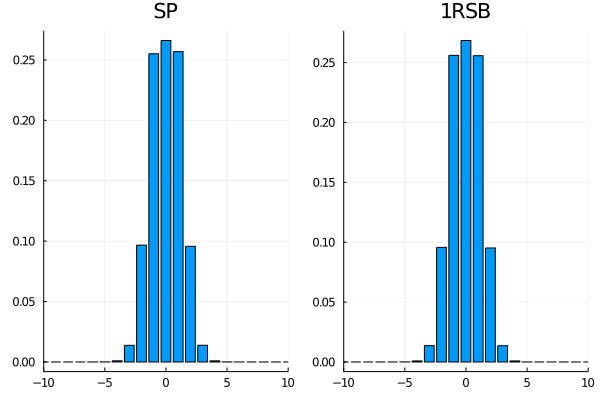

In [81]:
h1 = plotProb(avgP, title="SP", label="", xlim=(-10,10))
h2 = plotProb(avgPopP, title="1RSB", label="", xlim=(-10,10))
Plots.plot(h1,h2)

## Overlap

In [281]:
o_sp, f_sp, c_sp = overlap(sp)

(0.47652214561964434, -0.5795530384040203, 0.05151544639218797)

In [105]:
o_rsb, f_rsb, c_rsb = overlap1RSB(Λ,K; popP=popP, popQ=popQ, y=y, samples=10^6)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
  F:  -0.03917461501411628
  O:  0.5313041144511318
  D:  0.2343479427744341


(0.5313041144511318, -0.03917461501411628, -0.4921294994370155)

# 2. Decimation

In [285]:
function decimate!(sp, s; decsteps=10, freevars=collect(1:size(sp.H,2)), kw...)
    iteration!(sp; maxiter=100, kw...)
    cnt = 0
    maxvardeg = maximum(sum(sp.H, dims=2))
    while !isempty(freevars)
        cnt += 1
        iteration!(sp; maxiter=100, kw...)
        # rank variables
#         mag = map(p->p'eachindex(p), sp.survey)
        mag = [findmax([sum(p[begin:-1]), sum(p[1:end])]) for p in sp.survey]
        mag_sign = [(m[2] - 1.5)*2 for m in mag]
        sort!(freevars, by=i->abs(mag[i][1]))
        # fix the highest-ranked with a strong field
        freevars, tofix = freevars[1:end-decsteps-1], freevars[max(1,end-decsteps):end]
        println("Step $cnt - fixing: $tofix")
        sp.efield[tofix] .= maxvardeg*sp.J.*mag_sign[tofix]  
        # print parity
        σ = sign.(argmax.(sp2.survey))
        x = (1 .- σ)/2
        z = sp.H*x .% 2
        ovl = dot(σ, s) / length(s)
        println("Unsat ", sum(z), ". Free vars ", length(freevars), ". Ovl ", ovl)
    end
end

decimate! (generic function with 2 methods)

In [ ]:
# sp3 = deepcopy(sp2)
freevars = findall(abs.(sp3.efield) .!= 20)
decimate!(sp3, s, decsteps=0, freevars=freevars)

Step 1 - fixing: [4053]
Unsat 63.0. Free vars 498. Ovl 0.5354166666666667
Step 2 - fixing: [4789]
Unsat 63.0. Free vars 497. Ovl 0.5354166666666667
Step 3 - fixing: [5057]
Unsat 63.0. Free vars 496. Ovl 0.5354166666666667
Step 4 - fixing: [3361]
Unsat 63.0. Free vars 495. Ovl 0.5354166666666667
Step 5 - fixing: [246]
Unsat 63.0. Free vars 494. Ovl 0.5354166666666667
Step 6 - fixing: [4620]
Unsat 63.0. Free vars 493. Ovl 0.5354166666666667
Step 7 - fixing: [4579]
Unsat 63.0. Free vars 492. Ovl 0.5354166666666667
Step 8 - fixing: [3146]
Unsat 63.0. Free vars 491. Ovl 0.5354166666666667
Step 9 - fixing: [2536]
Unsat 63.0. Free vars 490. Ovl 0.5354166666666667
Step 10 - fixing: [5308]
Unsat 63.0. Free vars 489. Ovl 0.5354166666666667
Step 11 - fixing: [5030]
Unsat 63.0. Free vars 488. Ovl 0.5354166666666667
Step 12 - fixing: [4795]
Unsat 63.0. Free vars 487. Ovl 0.5354166666666667
Step 13 - fixing: [1712]
Unsat 63.0. Free vars 486. Ovl 0.5354166666666667
Step 14 - fixing: [1806]
Unsat 63.0

In [ ]:
callback(t, ε, sp) = (println("$t $ε"); false)
sp2 = deepcopy(sp)
decimate!(sp2, decsteps=0)

Step 1 - fixing: [5814]
Unsat checks: 392.5
Step 2 - fixing: [2297]
Unsat checks: 396.5
Step 3 - fixing: [3094]
Unsat checks: 394.5
Step 4 - fixing: [768]
Unsat checks: 394.5
Step 5 - fixing: [1559]
Unsat checks: 395.5
Step 6 - fixing: [3088]
Unsat checks: 395.5
Step 7 - fixing: [3343]
Unsat checks: 394.5
Step 8 - fixing: [5150]
Unsat checks: 394.5
Step 9 - fixing: [388]
Unsat checks: 394.5
Step 10 - fixing: [2836]
Unsat checks: 394.5
Step 11 - fixing: [2989]
Unsat checks: 394.5
Step 12 - fixing: [1560]
Unsat checks: 394.5
Step 13 - fixing: [1709]
Unsat checks: 394.5
Step 14 - fixing: [4284]
Unsat checks: 394.5
Step 15 - fixing: [5085]
Unsat checks: 394.5
Step 16 - fixing: [1512]
Unsat checks: 394.5
Step 17 - fixing: [558]
Unsat checks: 394.5
Step 18 - fixing: [659]
Unsat checks: 394.5
Step 19 - fixing: [5284]
Unsat checks: 394.5
Step 20 - fixing: [6500]
Unsat checks: 394.5
Step 21 - fixing: [1169]
Unsat checks: 394.5
Step 22 - fixing: [601]
Unsat checks: 394.5
Step 23 - fixing: [1667]

Step 183 - fixing: [4891]
Unsat checks: 395.5
Step 184 - fixing: [4900]
Unsat checks: 395.5
Step 185 - fixing: [2429]
Unsat checks: 395.5
Step 186 - fixing: [1124]
Unsat checks: 395.5
Step 187 - fixing: [6079]
Unsat checks: 395.5
Step 188 - fixing: [4233]
Unsat checks: 395.5
Step 189 - fixing: [4283]
Unsat checks: 395.5
Step 190 - fixing: [3948]
Unsat checks: 395.5
Step 191 - fixing: [4595]
Unsat checks: 395.5
Step 192 - fixing: [2630]
Unsat checks: 395.5
Step 193 - fixing: [3871]
Unsat checks: 395.5
Step 194 - fixing: [2288]
Unsat checks: 395.5
Step 195 - fixing: [2847]
Unsat checks: 395.5
Step 196 - fixing: [4841]
Unsat checks: 395.5
Step 197 - fixing: [467]
Unsat checks: 395.5
Step 198 - fixing: [3021]
Unsat checks: 395.5
Step 199 - fixing: [3903]
Unsat checks: 395.5
Step 200 - fixing: [1591]
Unsat checks: 395.5
Step 201 - fixing: [431]
Unsat checks: 395.5
Step 202 - fixing: [6271]
Unsat checks: 395.5
Step 203 - fixing: [5468]
Unsat checks: 395.5
Step 204 - fixing: [4575]
Unsat chec

Step 362 - fixing: [4671]
Unsat checks: 394.5
Step 363 - fixing: [6345]
Unsat checks: 394.5
Step 364 - fixing: [2302]
Unsat checks: 394.5
Step 365 - fixing: [6160]
Unsat checks: 394.5
Step 366 - fixing: [3921]
Unsat checks: 394.5
Step 367 - fixing: [4494]
Unsat checks: 394.5
Step 368 - fixing: [665]
Unsat checks: 394.5
Step 369 - fixing: [5383]
Unsat checks: 394.5
Step 370 - fixing: [2831]
Unsat checks: 394.5
Step 371 - fixing: [4207]
Unsat checks: 394.5
Step 372 - fixing: [148]
Unsat checks: 394.5
Step 373 - fixing: [4489]
Unsat checks: 394.5
Step 374 - fixing: [384]
Unsat checks: 394.5
Step 375 - fixing: [3235]
Unsat checks: 394.5
Step 376 - fixing: [4517]
Unsat checks: 394.5
Step 377 - fixing: [873]
Unsat checks: 394.5
Step 378 - fixing: [4801]
Unsat checks: 394.5
Step 379 - fixing: [5906]
Unsat checks: 394.5
Step 380 - fixing: [4008]
Unsat checks: 394.5
Step 381 - fixing: [4461]
Unsat checks: 394.5
Step 382 - fixing: [6047]
Unsat checks: 394.5
Step 383 - fixing: [3414]
Unsat checks

Step 541 - fixing: [3647]
Unsat checks: 392.5
Step 542 - fixing: [855]
Unsat checks: 390.5
Step 543 - fixing: [2785]
Unsat checks: 390.5
Step 544 - fixing: [3551]
Unsat checks: 390.5
Step 545 - fixing: [2960]
Unsat checks: 390.5
Step 546 - fixing: [5868]
Unsat checks: 390.5
Step 547 - fixing: [5060]
Unsat checks: 390.5
Step 548 - fixing: [1217]
Unsat checks: 390.5
Step 549 - fixing: [4378]
Unsat checks: 390.5
Step 550 - fixing: [6630]
Unsat checks: 390.5
Step 551 - fixing: [2567]
Unsat checks: 390.5
Step 552 - fixing: [3023]
Unsat checks: 390.5
Step 553 - fixing: [5275]
Unsat checks: 390.5
Step 554 - fixing: [2129]
Unsat checks: 389.5
Step 555 - fixing: [5251]
Unsat checks: 389.5
Step 556 - fixing: [1547]
Unsat checks: 389.5
Step 557 - fixing: [5000]
Unsat checks: 391.5
Step 558 - fixing: [259]
Unsat checks: 392.5
Step 559 - fixing: [1313]
Unsat checks: 392.5
Step 560 - fixing: [3947]
Unsat checks: 392.5
Step 561 - fixing: [924]
Unsat checks: 392.5
Step 562 - fixing: [6499]
Unsat check

Step 720 - fixing: [1775]
Unsat checks: 392.5
Step 721 - fixing: [5817]
Unsat checks: 392.5
Step 722 - fixing: [6199]
Unsat checks: 392.5
Step 723 - fixing: [4608]
Unsat checks: 392.5
Step 724 - fixing: [3497]
Unsat checks: 392.5
Step 725 - fixing: [4368]
Unsat checks: 392.5
Step 726 - fixing: [5519]
Unsat checks: 392.5
Step 727 - fixing: [1641]
Unsat checks: 392.5
Step 728 - fixing: [4661]
Unsat checks: 392.5
Step 729 - fixing: [4023]
Unsat checks: 392.5
Step 730 - fixing: [28]
Unsat checks: 392.5
Step 731 - fixing: [2834]
Unsat checks: 392.5
Step 732 - fixing: [6209]
Unsat checks: 392.5
Step 733 - fixing: [4152]
Unsat checks: 392.5
Step 734 - fixing: [5563]
Unsat checks: 392.5
Step 735 - fixing: [4454]
Unsat checks: 392.5
Step 736 - fixing: [1002]
Unsat checks: 392.5
Step 737 - fixing: [3062]
Unsat checks: 392.5
Step 738 - fixing: [2542]
Unsat checks: 392.5
Step 739 - fixing: [638]
Unsat checks: 392.5
Step 740 - fixing: [1677]
Unsat checks: 392.5
Step 741 - fixing: [4660]
Unsat check

Step 899 - fixing: [3002]
Unsat checks: 385.5
Step 900 - fixing: [78]
Unsat checks: 385.5
Step 901 - fixing: [4553]
Unsat checks: 385.5
Step 902 - fixing: [5904]
Unsat checks: 385.5
Step 903 - fixing: [3876]
Unsat checks: 385.5
Step 904 - fixing: [6204]
Unsat checks: 385.5
Step 905 - fixing: [2009]
Unsat checks: 385.5
Step 906 - fixing: [5069]
Unsat checks: 384.5
Step 907 - fixing: [6087]
Unsat checks: 381.5
Step 908 - fixing: [115]
Unsat checks: 381.5
Step 909 - fixing: [4200]
Unsat checks: 381.5
Step 910 - fixing: [5895]
Unsat checks: 381.5
Step 911 - fixing: [197]
Unsat checks: 381.5
Step 912 - fixing: [6666]
Unsat checks: 381.5
Step 913 - fixing: [1211]
Unsat checks: 381.5
Step 914 - fixing: [5424]
Unsat checks: 381.5
Step 915 - fixing: [6436]
Unsat checks: 381.5
Step 916 - fixing: [1751]
Unsat checks: 381.5
Step 917 - fixing: [3231]
Unsat checks: 381.5
Step 918 - fixing: [3054]
Unsat checks: 381.5
Step 919 - fixing: [4230]
Unsat checks: 381.5
Step 920 - fixing: [3556]
Unsat checks

Step 1076 - fixing: [5708]
Unsat checks: 371.5
Step 1077 - fixing: [3864]
Unsat checks: 372.5
Step 1078 - fixing: [439]
Unsat checks: 371.5
Step 1079 - fixing: [5565]
Unsat checks: 371.5
Step 1080 - fixing: [3824]
Unsat checks: 371.5
Step 1081 - fixing: [3029]
Unsat checks: 371.5
Step 1082 - fixing: [4641]
Unsat checks: 371.5
Step 1083 - fixing: [799]
Unsat checks: 371.5
Step 1084 - fixing: [6307]
Unsat checks: 371.5
Step 1085 - fixing: [1335]
Unsat checks: 371.5
Step 1086 - fixing: [1277]
Unsat checks: 371.5
Step 1087 - fixing: [1411]
Unsat checks: 373.5
Step 1088 - fixing: [6690]
Unsat checks: 373.5
Step 1089 - fixing: [2381]
Unsat checks: 373.5
Step 1090 - fixing: [4759]
Unsat checks: 373.5
Step 1091 - fixing: [1029]
Unsat checks: 373.5
Step 1092 - fixing: [5101]
Unsat checks: 373.5
Step 1093 - fixing: [4779]
Unsat checks: 373.5
Step 1094 - fixing: [2108]
Unsat checks: 373.5
Step 1095 - fixing: [202]
Unsat checks: 373.5
Step 1096 - fixing: [952]
Unsat checks: 373.5
Step 1097 - fixin

Step 1251 - fixing: [331]
Unsat checks: 360.5
Step 1252 - fixing: [3043]
Unsat checks: 357.5
Step 1253 - fixing: [4518]
Unsat checks: 362.5
Step 1254 - fixing: [3475]
Unsat checks: 361.5
Step 1255 - fixing: [4137]
Unsat checks: 361.5
Step 1256 - fixing: [313]
Unsat checks: 361.5
Step 1257 - fixing: [4882]
Unsat checks: 361.5
Step 1258 - fixing: [4839]
Unsat checks: 361.5
Step 1259 - fixing: [3968]
Unsat checks: 361.5
Step 1260 - fixing: [5124]
Unsat checks: 361.5
Step 1261 - fixing: [6634]
Unsat checks: 361.5
Step 1262 - fixing: [61]
Unsat checks: 361.5
Step 1263 - fixing: [5281]
Unsat checks: 361.5
Step 1264 - fixing: [1617]
Unsat checks: 359.5
Step 1265 - fixing: [5993]
Unsat checks: 359.5
Step 1266 - fixing: [3347]
Unsat checks: 353.5
Step 1267 - fixing: [5230]
Unsat checks: 353.5
Step 1268 - fixing: [1061]
Unsat checks: 353.5
Step 1269 - fixing: [3037]
Unsat checks: 353.5
Step 1270 - fixing: [5933]
Unsat checks: 355.5
Step 1271 - fixing: [2142]
Unsat checks: 356.5
Step 1272 - fixin

Step 1426 - fixing: [5769]
Unsat checks: 340.5
Step 1427 - fixing: [3700]
Unsat checks: 342.5
Step 1428 - fixing: [3038]
Unsat checks: 344.5
Step 1429 - fixing: [4399]
Unsat checks: 344.5
Step 1430 - fixing: [557]
Unsat checks: 344.5
Step 1431 - fixing: [6616]
Unsat checks: 342.5
Step 1432 - fixing: [6491]
Unsat checks: 344.5
Step 1433 - fixing: [1209]
Unsat checks: 340.5
Step 1434 - fixing: [3928]
Unsat checks: 340.5
Step 1435 - fixing: [3277]
Unsat checks: 340.5
Step 1436 - fixing: [4629]
Unsat checks: 340.5
Step 1437 - fixing: [622]
Unsat checks: 340.5
Step 1438 - fixing: [512]
Unsat checks: 340.5
Step 1439 - fixing: [6368]
Unsat checks: 340.5
Step 1440 - fixing: [803]
Unsat checks: 340.5
Step 1441 - fixing: [4733]
Unsat checks: 340.5
Step 1442 - fixing: [6470]
Unsat checks: 340.5
Step 1443 - fixing: [5015]
Unsat checks: 340.5
Step 1444 - fixing: [6122]
Unsat checks: 340.5
Step 1445 - fixing: [724]
Unsat checks: 340.5
Step 1446 - fixing: [3049]
Unsat checks: 340.5
Step 1447 - fixing

Step 1602 - fixing: [6254]
Unsat checks: 350.5
Step 1603 - fixing: [2778]
Unsat checks: 350.5
Step 1604 - fixing: [3155]
Unsat checks: 350.5
Step 1605 - fixing: [4697]
Unsat checks: 350.5
Step 1606 - fixing: [3139]
Unsat checks: 350.5
Step 1607 - fixing: [1981]
Unsat checks: 350.5
Step 1608 - fixing: [2543]
Unsat checks: 350.5
Step 1609 - fixing: [5375]
Unsat checks: 350.5
Step 1610 - fixing: [3126]
Unsat checks: 350.5
Step 1611 - fixing: [4558]
Unsat checks: 350.5
Step 1612 - fixing: [1359]
Unsat checks: 350.5
Step 1613 - fixing: [3878]
Unsat checks: 348.5
Step 1614 - fixing: [1306]
Unsat checks: 348.5
Step 1615 - fixing: [6566]
Unsat checks: 352.5
Step 1616 - fixing: [4314]
Unsat checks: 352.5
Step 1617 - fixing: [951]
Unsat checks: 352.5
Step 1618 - fixing: [5005]
Unsat checks: 352.5
Step 1619 - fixing: [4480]
Unsat checks: 354.5
Step 1620 - fixing: [6062]
Unsat checks: 354.5
Step 1621 - fixing: [4046]
Unsat checks: 353.5
Step 1622 - fixing: [24]
Unsat checks: 353.5
Step 1623 - fixi

Step 1777 - fixing: [4653]
Unsat checks: 348.5
Step 1778 - fixing: [6100]
Unsat checks: 351.5
Step 1779 - fixing: [1704]
Unsat checks: 351.5
Step 1780 - fixing: [1765]
Unsat checks: 351.5
Step 1781 - fixing: [4268]
Unsat checks: 351.5
Step 1782 - fixing: [1523]
Unsat checks: 351.5
Step 1783 - fixing: [5747]
Unsat checks: 352.5
Step 1784 - fixing: [5884]
Unsat checks: 352.5
Step 1785 - fixing: [6003]
Unsat checks: 352.5
Step 1786 - fixing: [5902]
Unsat checks: 352.5
Step 1787 - fixing: [3356]
Unsat checks: 352.5
Step 1788 - fixing: [6430]
Unsat checks: 352.5
Step 1789 - fixing: [1159]
Unsat checks: 352.5
Step 1790 - fixing: [880]
Unsat checks: 351.5
Step 1791 - fixing: [3969]
Unsat checks: 351.5
Step 1792 - fixing: [4030]
Unsat checks: 351.5
Step 1793 - fixing: [141]
Unsat checks: 351.5
Step 1794 - fixing: [4108]
Unsat checks: 351.5
Step 1795 - fixing: [4296]
Unsat checks: 351.5
Step 1796 - fixing: [288]
Unsat checks: 351.5
Step 1797 - fixing: [2648]
Unsat checks: 351.5
Step 1798 - fixi

Step 1952 - fixing: [671]
Unsat checks: 346.5
Step 1953 - fixing: [6432]
Unsat checks: 346.5
Step 1954 - fixing: [6437]
Unsat checks: 346.5
Step 1955 - fixing: [6532]
Unsat checks: 346.5
Step 1956 - fixing: [5316]
Unsat checks: 346.5
Step 1957 - fixing: [1273]
Unsat checks: 346.5
Step 1958 - fixing: [4888]
Unsat checks: 346.5
Step 1959 - fixing: [6069]
Unsat checks: 343.5
Step 1960 - fixing: [5303]
Unsat checks: 345.5
Step 1961 - fixing: [5717]
Unsat checks: 343.5
Step 1962 - fixing: [696]
Unsat checks: 345.5
Step 1963 - fixing: [3987]
Unsat checks: 339.5
Step 1964 - fixing: [5307]
Unsat checks: 339.5
Step 1965 - fixing: [4851]
Unsat checks: 340.5
Step 1966 - fixing: [1694]
Unsat checks: 340.5
Step 1967 - fixing: [5716]
Unsat checks: 340.5
Step 1968 - fixing: [6406]
Unsat checks: 340.5
Step 1969 - fixing: [4952]
Unsat checks: 339.5
Step 1970 - fixing: [914]
Unsat checks: 339.5
Step 1971 - fixing: [937]
Unsat checks: 339.5
Step 1972 - fixing: [172]
Unsat checks: 342.5
Step 1973 - fixing

Step 2127 - fixing: [258]
Unsat checks: 334.0
Step 2128 - fixing: [6688]
Unsat checks: 334.0
Step 2129 - fixing: [4027]
Unsat checks: 334.0
Step 2130 - fixing: [3305]
Unsat checks: 334.0
Step 2131 - fixing: [1058]
Unsat checks: 334.0
Step 2132 - fixing: [2285]
Unsat checks: 334.0
Step 2133 - fixing: [1644]
Unsat checks: 334.0
Step 2134 - fixing: [5843]
Unsat checks: 334.0
Step 2135 - fixing: [1059]
Unsat checks: 334.0
Step 2136 - fixing: [5772]
Unsat checks: 333.0
Step 2137 - fixing: [2946]
Unsat checks: 333.0
Step 2138 - fixing: [5862]
Unsat checks: 333.0
Step 2139 - fixing: [4232]
Unsat checks: 333.0
Step 2140 - fixing: [2991]
Unsat checks: 333.0
Step 2141 - fixing: [260]
Unsat checks: 332.0
Step 2142 - fixing: [2083]
Unsat checks: 332.0
Step 2143 - fixing: [1639]
Unsat checks: 332.0
Step 2144 - fixing: [4694]
Unsat checks: 335.0
Step 2145 - fixing: [6232]
Unsat checks: 335.0
Step 2146 - fixing: [3478]
Unsat checks: 335.0
Step 2147 - fixing: [4147]
Unsat checks: 334.0
Step 2148 - fix

Step 2303 - fixing: [6401]
Unsat checks: 327.0
Step 2304 - fixing: [5625]
Unsat checks: 327.0
Step 2305 - fixing: [154]
Unsat checks: 332.0
Step 2306 - fixing: [6146]
Unsat checks: 333.0
Step 2307 - fixing: [1845]
Unsat checks: 332.0
Step 2308 - fixing: [87]
Unsat checks: 333.0
Step 2309 - fixing: [1446]
Unsat checks: 332.0
Step 2310 - fixing: [5601]
Unsat checks: 332.0
Step 2311 - fixing: [5346]
Unsat checks: 332.0
Step 2312 - fixing: [6282]
Unsat checks: 332.0
Step 2313 - fixing: [3747]
Unsat checks: 331.0
Step 2314 - fixing: [2499]
Unsat checks: 331.0
Step 2315 - fixing: [310]
Unsat checks: 331.0
Step 2316 - fixing: [1458]
Unsat checks: 331.0
Step 2317 - fixing: [1255]
Unsat checks: 327.0
Step 2318 - fixing: [3550]
Unsat checks: 327.0
Step 2319 - fixing: [5228]
Unsat checks: 327.0
Step 2320 - fixing: [3107]
Unsat checks: 327.0
Step 2321 - fixing: [843]
Unsat checks: 324.0
Step 2322 - fixing: [6296]
Unsat checks: 324.0
Step 2323 - fixing: [3136]
Unsat checks: 325.0
Step 2324 - fixing

Step 2478 - fixing: [4353]
Unsat checks: 306.0
Step 2479 - fixing: [1569]
Unsat checks: 306.0
Step 2480 - fixing: [5572]
Unsat checks: 305.0
Step 2481 - fixing: [653]
Unsat checks: 305.0
Step 2482 - fixing: [3102]
Unsat checks: 305.0
Step 2483 - fixing: [4690]
Unsat checks: 305.0
Step 2484 - fixing: [5965]
Unsat checks: 305.0
Step 2485 - fixing: [4907]
Unsat checks: 305.0
Step 2486 - fixing: [6453]
Unsat checks: 305.0
Step 2487 - fixing: [372]
Unsat checks: 305.0
Step 2488 - fixing: [2472]
Unsat checks: 305.0
Step 2489 - fixing: [5056]
Unsat checks: 305.0
Step 2490 - fixing: [6114]
Unsat checks: 305.0
Step 2491 - fixing: [309]
Unsat checks: 305.0
Step 2492 - fixing: [1145]
Unsat checks: 305.0
Step 2493 - fixing: [4920]
Unsat checks: 305.0
Step 2494 - fixing: [5415]
Unsat checks: 304.0
Step 2495 - fixing: [4281]
Unsat checks: 302.0
Step 2496 - fixing: [5918]
Unsat checks: 302.0
Step 2497 - fixing: [5157]
Unsat checks: 305.0
Step 2498 - fixing: [113]
Unsat checks: 304.0
Step 2499 - fixin

Step 2707 - fixing: [3862]
Unsat checks: 305.0
Step 2708 - fixing: [168]
Unsat checks: 304.0
Step 2709 - fixing: [6507]
Unsat checks: 304.0
Step 2710 - fixing: [4867]
Unsat checks: 304.0
Step 2711 - fixing: [2367]
Unsat checks: 304.0
Step 2712 - fixing: [3059]
Unsat checks: 305.0
Step 2713 - fixing: [361]
Unsat checks: 304.0
Step 2714 - fixing: [3452]
Unsat checks: 304.0
Step 2715 - fixing: [4986]
Unsat checks: 304.0
Step 2716 - fixing: [3189]
Unsat checks: 304.0
Step 2717 - fixing: [6526]
Unsat checks: 304.0
Step 2718 - fixing: [1278]
Unsat checks: 304.0
Step 2719 - fixing: [6376]
Unsat checks: 304.0
Step 2720 - fixing: [5504]
Unsat checks: 304.0
Step 2721 - fixing: [3079]
Unsat checks: 304.0
Step 2722 - fixing: [885]
Unsat checks: 304.0
Step 2723 - fixing: [5681]
Unsat checks: 306.0
Step 2724 - fixing: [446]
Unsat checks: 306.0
Step 2725 - fixing: [4422]
Unsat checks: 308.0
Step 2726 - fixing: [6346]
Unsat checks: 308.0
Step 2727 - fixing: [3775]
Unsat checks: 304.0
Step 2728 - fixin

Step 2882 - fixing: [945]
Unsat checks: 290.0
Step 2883 - fixing: [6092]
Unsat checks: 290.0
Step 2884 - fixing: [1429]
Unsat checks: 290.0
Step 2885 - fixing: [161]
Unsat checks: 290.0
Step 2886 - fixing: [1509]
Unsat checks: 290.0
Step 2887 - fixing: [4470]
Unsat checks: 290.0
Step 2888 - fixing: [5392]
Unsat checks: 290.0
Step 2889 - fixing: [2128]
Unsat checks: 294.0
Step 2890 - fixing: [1405]
Unsat checks: 292.0
Step 2891 - fixing: [726]
Unsat checks: 294.0
Step 2892 - fixing: [3060]
Unsat checks: 294.0
Step 2893 - fixing: [3091]
Unsat checks: 294.0
Step 2894 - fixing: [6460]
Unsat checks: 294.0
Step 2895 - fixing: [6672]
Unsat checks: 294.0
Step 2896 - fixing: [5442]
Unsat checks: 294.0
Step 2897 - fixing: [6394]
Unsat checks: 294.0
Step 2898 - fixing: [4352]
Unsat checks: 294.0
Step 2899 - fixing: [63]
Unsat checks: 294.0
Step 2900 - fixing: [2592]
Unsat checks: 294.0
Step 2901 - fixing: [1047]
Unsat checks: 294.0
Step 2902 - fixing: [2714]
Unsat checks: 293.0
Step 2903 - fixing

Step 3057 - fixing: [1926]
Unsat checks: 282.0
Step 3058 - fixing: [5813]
Unsat checks: 283.0
Step 3059 - fixing: [2071]
Unsat checks: 283.0
Step 3060 - fixing: [974]
Unsat checks: 283.0
Step 3061 - fixing: [5387]
Unsat checks: 283.0
Step 3062 - fixing: [5049]
Unsat checks: 283.0
Step 3063 - fixing: [6535]
Unsat checks: 283.0
Step 3064 - fixing: [1552]
Unsat checks: 283.0
Step 3065 - fixing: [5382]
Unsat checks: 283.0
Step 3066 - fixing: [233]
Unsat checks: 279.0
Step 3067 - fixing: [4319]
Unsat checks: 279.0
Step 3068 - fixing: [5908]
Unsat checks: 279.0
Step 3069 - fixing: [2965]
Unsat checks: 279.0
Step 3070 - fixing: [1850]
Unsat checks: 279.0
Step 3071 - fixing: [3283]
Unsat checks: 279.0
Step 3072 - fixing: [2312]
Unsat checks: 279.0
Step 3073 - fixing: [3108]
Unsat checks: 279.0
Step 3074 - fixing: [826]
Unsat checks: 281.0
Step 3075 - fixing: [5779]
Unsat checks: 279.0
Step 3076 - fixing: [470]
Unsat checks: 279.0
Step 3077 - fixing: [3350]
Unsat checks: 280.0
Step 3078 - fixin

Step 3232 - fixing: [6673]
Unsat checks: 283.0
Step 3233 - fixing: [4478]
Unsat checks: 283.0
Step 3234 - fixing: [5320]
Unsat checks: 283.0
Step 3235 - fixing: [6030]
Unsat checks: 283.0
Step 3236 - fixing: [6423]
Unsat checks: 283.0
Step 3237 - fixing: [4965]
Unsat checks: 283.0
Step 3238 - fixing: [6188]
Unsat checks: 283.0
Step 3239 - fixing: [3879]
Unsat checks: 283.0
Step 3240 - fixing: [529]
Unsat checks: 276.0
Step 3241 - fixing: [3860]
Unsat checks: 276.0
Step 3242 - fixing: [4677]
Unsat checks: 276.0
Step 3243 - fixing: [2723]
Unsat checks: 276.0
Step 3244 - fixing: [2690]
Unsat checks: 273.0
Step 3245 - fixing: [4151]
Unsat checks: 275.0
Step 3246 - fixing: [3614]
Unsat checks: 275.0
Step 3247 - fixing: [3427]
Unsat checks: 276.0
Step 3248 - fixing: [2003]
Unsat checks: 276.0
Step 3249 - fixing: [2818]
Unsat checks: 276.0
Step 3250 - fixing: [5956]
Unsat checks: 276.0
Step 3251 - fixing: [2538]
Unsat checks: 276.0
Step 3252 - fixing: [2913]
Unsat checks: 276.0
Step 3253 - fi

Step 3407 - fixing: [6228]
Unsat checks: 276.0
Step 3408 - fixing: [6669]
Unsat checks: 276.0
Step 3409 - fixing: [5390]
Unsat checks: 276.0
Step 3410 - fixing: [17]
Unsat checks: 276.0
Step 3411 - fixing: [6379]
Unsat checks: 276.0
Step 3412 - fixing: [472]
Unsat checks: 276.0
Step 3413 - fixing: [4777]
Unsat checks: 276.0
Step 3414 - fixing: [1651]
Unsat checks: 274.0
Step 3415 - fixing: [3565]
Unsat checks: 274.0
Step 3416 - fixing: [4299]
Unsat checks: 272.0
Step 3417 - fixing: [3132]
Unsat checks: 272.0
Step 3418 - fixing: [1037]
Unsat checks: 272.0
Step 3419 - fixing: [6686]
Unsat checks: 272.0
Step 3420 - fixing: [6623]
Unsat checks: 272.0
Step 3421 - fixing: [2254]
Unsat checks: 272.0
Step 3422 - fixing: [5451]
Unsat checks: 272.0
Step 3423 - fixing: [631]
Unsat checks: 272.0
Step 3424 - fixing: [3745]
Unsat checks: 272.0
Step 3425 - fixing: [3538]
Unsat checks: 272.0
Step 3426 - fixing: [6306]
Unsat checks: 272.0
Step 3427 - fixing: [4834]
Unsat checks: 272.0
Step 3428 - fixin

Step 3582 - fixing: [3284]
Unsat checks: 265.0
Step 3583 - fixing: [864]
Unsat checks: 265.0
Step 3584 - fixing: [5984]
Unsat checks: 265.0
Step 3585 - fixing: [5806]
Unsat checks: 265.0
Step 3586 - fixing: [2027]
Unsat checks: 265.0
Step 3587 - fixing: [2973]
Unsat checks: 265.0
Step 3588 - fixing: [3237]
Unsat checks: 267.0
Step 3589 - fixing: [1700]
Unsat checks: 267.0
Step 3590 - fixing: [4948]
Unsat checks: 267.0
Step 3591 - fixing: [356]
Unsat checks: 267.0
Step 3592 - fixing: [5027]
Unsat checks: 267.0
Step 3593 - fixing: [417]
Unsat checks: 267.0
Step 3594 - fixing: [5159]
Unsat checks: 267.0
Step 3595 - fixing: [4530]
Unsat checks: 267.0
Step 3596 - fixing: [2821]
Unsat checks: 262.0
Step 3597 - fixing: [4788]
Unsat checks: 262.0
Step 3598 - fixing: [5624]
Unsat checks: 262.0
Step 3599 - fixing: [4054]
Unsat checks: 262.0
Step 3600 - fixing: [1793]
Unsat checks: 262.0
Step 3601 - fixing: [4644]
Unsat checks: 262.0
Step 3602 - fixing: [783]
Unsat checks: 262.0
Step 3603 - fixin

Step 3757 - fixing: [5318]
Unsat checks: 260.0
Step 3758 - fixing: [3901]
Unsat checks: 260.0
Step 3759 - fixing: [3751]
Unsat checks: 258.0
Step 3760 - fixing: [5638]
Unsat checks: 260.0
Step 3761 - fixing: [6371]
Unsat checks: 260.0
Step 3762 - fixing: [3393]
Unsat checks: 254.0
Step 3763 - fixing: [3991]
Unsat checks: 254.0
Step 3764 - fixing: [5602]
Unsat checks: 254.0
Step 3765 - fixing: [5306]
Unsat checks: 254.0
Step 3766 - fixing: [4947]
Unsat checks: 254.0
Step 3767 - fixing: [5639]
Unsat checks: 254.0
Step 3768 - fixing: [5583]
Unsat checks: 254.0
Step 3769 - fixing: [2760]
Unsat checks: 254.0
Step 3770 - fixing: [1484]
Unsat checks: 254.0
Step 3771 - fixing: [6270]
Unsat checks: 254.0
Step 3772 - fixing: [2044]
Unsat checks: 255.0
Step 3773 - fixing: [2822]
Unsat checks: 255.0
Step 3774 - fixing: [5724]
Unsat checks: 255.0
Step 3775 - fixing: [1772]
Unsat checks: 255.0
Step 3776 - fixing: [1325]
Unsat checks: 255.0
Step 3777 - fixing: [4118]
Unsat checks: 255.0
Step 3778 - f

Step 3932 - fixing: [6650]
Unsat checks: 239.0
Step 3933 - fixing: [6042]
Unsat checks: 239.0
Step 3934 - fixing: [981]
Unsat checks: 239.0
Step 3935 - fixing: [3406]
Unsat checks: 240.0
Step 3936 - fixing: [4627]
Unsat checks: 240.0
Step 3937 - fixing: [4226]
Unsat checks: 237.0
Step 3938 - fixing: [5785]
Unsat checks: 237.0
Step 3939 - fixing: [902]
Unsat checks: 237.0
Step 3940 - fixing: [75]
Unsat checks: 237.0
Step 3941 - fixing: [2932]
Unsat checks: 239.0
Step 3942 - fixing: [1435]
Unsat checks: 235.0
Step 3943 - fixing: [3643]
Unsat checks: 233.0
Step 3944 - fixing: [1450]
Unsat checks: 233.0
Step 3945 - fixing: [2999]
Unsat checks: 233.0
Step 3946 - fixing: [5634]
Unsat checks: 233.0
Step 3947 - fixing: [6333]
Unsat checks: 233.0
Step 3948 - fixing: [1121]
Unsat checks: 233.0
Step 3949 - fixing: [5517]
Unsat checks: 233.0
Step 3950 - fixing: [6326]
Unsat checks: 233.0
Step 3951 - fixing: [1508]
Unsat checks: 232.0
Step 3952 - fixing: [402]
Unsat checks: 232.0
Step 3953 - fixing

Step 4107 - fixing: [2686]
Unsat checks: 208.0
Step 4108 - fixing: [321]
Unsat checks: 208.0
Step 4109 - fixing: [5328]
Unsat checks: 208.0
Step 4110 - fixing: [1224]
Unsat checks: 208.0
Step 4111 - fixing: [6416]
Unsat checks: 208.0
Step 4112 - fixing: [1745]
Unsat checks: 208.0
Step 4113 - fixing: [5512]
Unsat checks: 208.0
Step 4114 - fixing: [6286]
Unsat checks: 208.0
Step 4115 - fixing: [5927]
Unsat checks: 208.0
Step 4116 - fixing: [1391]
Unsat checks: 208.0
Step 4117 - fixing: [2294]
Unsat checks: 208.0
Step 4118 - fixing: [4548]
Unsat checks: 208.0
Step 4119 - fixing: [5637]
Unsat checks: 208.0
Step 4120 - fixing: [5490]
Unsat checks: 208.0
Step 4121 - fixing: [1920]
Unsat checks: 208.0
Step 4122 - fixing: [5712]
Unsat checks: 208.0
Step 4123 - fixing: [5840]
Unsat checks: 208.0
Step 4124 - fixing: [6677]
Unsat checks: 208.0
Step 4125 - fixing: [3516]
Unsat checks: 208.0
Step 4126 - fixing: [3729]
Unsat checks: 208.0
Step 4127 - fixing: [6519]
Unsat checks: 208.0
Step 4128 - fi

Step 4282 - fixing: [184]
Unsat checks: 192.0
Step 4283 - fixing: [3677]
Unsat checks: 192.0
Step 4284 - fixing: [5745]
Unsat checks: 192.0
Step 4285 - fixing: [1152]
Unsat checks: 192.0
Step 4286 - fixing: [3207]
Unsat checks: 192.0
Step 4287 - fixing: [1380]
Unsat checks: 192.0
Step 4288 - fixing: [1108]
Unsat checks: 192.0
Step 4289 - fixing: [4394]
Unsat checks: 192.0
Step 4290 - fixing: [1721]
Unsat checks: 192.0
Step 4291 - fixing: [3728]
Unsat checks: 192.0
Step 4292 - fixing: [5398]
Unsat checks: 192.0
Step 4293 - fixing: [6498]
Unsat checks: 192.0
Step 4294 - fixing: [5319]
Unsat checks: 192.0
Step 4295 - fixing: [2347]
Unsat checks: 192.0
Step 4296 - fixing: [5071]
Unsat checks: 192.0
Step 4297 - fixing: [2739]
Unsat checks: 192.0
Step 4298 - fixing: [6538]
Unsat checks: 192.0
Step 4299 - fixing: [1174]
Unsat checks: 192.0
Step 4300 - fixing: [1961]
Unsat checks: 190.0
Step 4301 - fixing: [1272]
Unsat checks: 192.0
Step 4302 - fixing: [6525]
Unsat checks: 189.0
Step 4303 - fi

Step 4457 - fixing: [5762]
Unsat checks: 208.0
Step 4458 - fixing: [4216]
Unsat checks: 208.0
Step 4459 - fixing: [5947]
Unsat checks: 208.0
Step 4460 - fixing: [5205]
Unsat checks: 208.0
Step 4461 - fixing: [2794]
Unsat checks: 208.0
Step 4462 - fixing: [5023]
Unsat checks: 208.0
Step 4463 - fixing: [3575]
Unsat checks: 208.0
Step 4464 - fixing: [4823]
Unsat checks: 208.0
Step 4465 - fixing: [1201]
Unsat checks: 208.0
Step 4466 - fixing: [2109]
Unsat checks: 208.0
Step 4467 - fixing: [1646]
Unsat checks: 208.0
Step 4468 - fixing: [1023]
Unsat checks: 208.0
Step 4469 - fixing: [3899]
Unsat checks: 208.0
Step 4470 - fixing: [4970]
Unsat checks: 208.0
Step 4471 - fixing: [2339]
Unsat checks: 208.0
Step 4472 - fixing: [3753]
Unsat checks: 206.0
Step 4473 - fixing: [5467]
Unsat checks: 206.0
Step 4474 - fixing: [1863]
Unsat checks: 206.0
Step 4475 - fixing: [3942]
Unsat checks: 206.0
Step 4476 - fixing: [5498]
Unsat checks: 206.0
Step 4477 - fixing: [2881]
Unsat checks: 206.0
Step 4478 - f

Step 4632 - fixing: [6347]
Unsat checks: 165.0
Step 4633 - fixing: [3243]
Unsat checks: 165.0
Step 4634 - fixing: [5336]
Unsat checks: 165.0
Step 4635 - fixing: [1344]
Unsat checks: 165.0
Step 4636 - fixing: [2060]
Unsat checks: 165.0
Step 4637 - fixing: [3120]
Unsat checks: 165.0
Step 4638 - fixing: [5711]
Unsat checks: 165.0
Step 4639 - fixing: [2007]
Unsat checks: 165.0
Step 4640 - fixing: [1533]
Unsat checks: 167.0
Step 4641 - fixing: [3482]
Unsat checks: 167.0
Step 4642 - fixing: [1548]
Unsat checks: 167.0
Step 4643 - fixing: [2026]
Unsat checks: 167.0
Step 4644 - fixing: [2144]
Unsat checks: 167.0
Step 4645 - fixing: [6019]
Unsat checks: 167.0
Step 4646 - fixing: [6179]
Unsat checks: 167.0
Step 4647 - fixing: [5776]
Unsat checks: 167.0
Step 4648 - fixing: [1024]
Unsat checks: 167.0
Step 4649 - fixing: [2004]
Unsat checks: 167.0
Step 4650 - fixing: [3095]
Unsat checks: 167.0
Step 4651 - fixing: [6357]
Unsat checks: 165.0
Step 4652 - fixing: [670]
Unsat checks: 165.0
Step 4653 - fi

Step 4807 - fixing: [3413]
Unsat checks: 146.0
Step 4808 - fixing: [6696]
Unsat checks: 142.0
Step 4809 - fixing: [4141]
Unsat checks: 142.0
Step 4810 - fixing: [15]
Unsat checks: 140.0
Step 4811 - fixing: [3645]
Unsat checks: 140.0
Step 4812 - fixing: [5800]
Unsat checks: 140.0
Step 4813 - fixing: [5974]
Unsat checks: 140.0
Step 4814 - fixing: [2278]
Unsat checks: 140.0
Step 4815 - fixing: [3790]
Unsat checks: 140.0
Step 4816 - fixing: [2435]
Unsat checks: 140.0
Step 4817 - fixing: [3327]
Unsat checks: 140.0
Step 4818 - fixing: [3714]
Unsat checks: 140.0
Step 4819 - fixing: [581]
Unsat checks: 140.0
Step 4820 - fixing: [5282]
Unsat checks: 140.0
Step 4821 - fixing: [5128]
Unsat checks: 140.0
Step 4822 - fixing: [466]
Unsat checks: 140.0
Step 4823 - fixing: [4058]
Unsat checks: 140.0
Step 4824 - fixing: [3945]
Unsat checks: 140.0
Step 4825 - fixing: [6130]
Unsat checks: 140.0
Step 4826 - fixing: [6201]
Unsat checks: 140.0
Step 4827 - fixing: [1364]
Unsat checks: 140.0
Step 4828 - fixin

In [247]:
σ = sign.(argmax.(sp2.survey))
x = (1 .- σ)/2
z = sp.H*x .% 2
sum(z)

63.0

In [255]:
α = size(sp.H,1)/size(sp.H,2)
ovl = dot(σ, s)/n
dist = (1-ovl)/2

0.23229166666666667

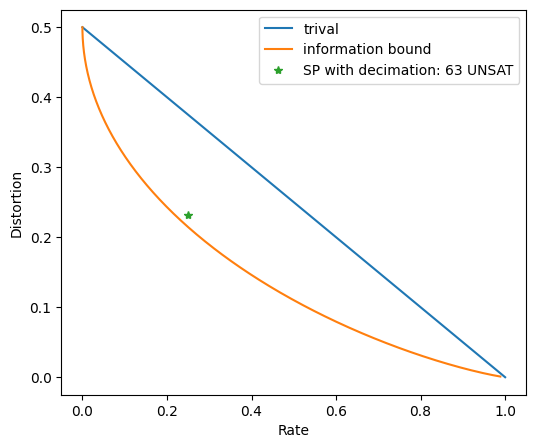

PyObject <matplotlib.legend.Legend object at 0x7fd59e4624e0>

In [257]:
HH(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = PyPlot.subplots(figsize=(6,5))
PyPlot.xlabel("Rate")
PyPlot.ylabel("Distortion")
PyPlot.plot((0,1),(0.5,0), label="trival")
PyPlot.plot(HH.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
PyPlot.plot(1-α,dist, "*", label="SP with decimation: 63 UNSAT")
legend()

In [263]:
findall(abs.(sp2.efield) .!= 20)

499-element Array{Int64,1}:
   46
   68
   81
   83
   91
   95
   98
  129
  133
  143
  156
  194
  208
    ⋮
 6185
 6289
 6311
 6324
 6332
 6354
 6422
 6459
 6477
 6579
 6615
 6697

# 3. Varying rate

In [202]:
using Unzip
ProgressMeter.ijulia_behavior(:clear)
y = 0.2
J = 30

rs = 0:0.1:0.9
Rs=fill(NaN, eachindex(rs))
D_sp=fill(NaN, eachindex(rs))
D_rsb=fill(NaN, eachindex(rs))

for (i,r) in pairs(rs)
    println("### Rate $i of $(length(rs))")
    Λ = [0,1-r,r]
    K = [0,0,1]
    mK = sum(k*K[k] for k=eachindex(K))
    mΛ = sum(d*Λ[d] for d=eachindex(Λ))
    α = mΛ/mK
    R=1-α
    # Single instance
    n = 100*3*7
    m = round(Int, n/3*(2+r))
    nedges = 3m
    lambda, rho = nodes2edges(Λ[1:end], K[1:end])
    H = ldpc_graphGF2(n,m,nedges,lambda,rho).H
    s = rand((-1,1), size(H,2))
    init = OffsetArray(MVector{2J+1}(fill(1/(2J+1),2J+1)), -J:J)
    sp = survey_propagation(H; field=s, init, y=y)
    iteration!(sp, maxiter=1000, damp=0.5, tol=1e-6)
    O = overlap(sp)
    D_sp[i] = (1-O)/2
    # 1RSB
    popsize=10^6
    popP, popQ = RSB(Λ,K; J=J, maxiter=10^2, popsize=popsize, y=y)
    O,_,_ = overlap1RSB(Λ,K; popP=popP, popQ=popQ, y=y, samples=10^6)
    D_rsb[i] = (1-O)/2
    Rs[i] = R
end

### Rate 1 of 10


Progress:   1%|▍                                        |  ETA: 0:02:31
4m  err:  0.015627803460753622/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:02:29
4m  err:  0.023982680773573854/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:02:27
4m  err:  0.04058900931805648/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:02:25
4m  err:  0.06001120485646266/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:02:24
4m  err:  0.059976951755359/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:02:22
4m  err:  0.07778708398329523/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:02:21
4m  err:  0.035047236485076294/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:02:19
4m  err:  0.04305707781829016/3.3333333333333335e-5
Progres

4m  err:  0.004073821618312823/3.3333333333333335e-5
Progress:  59%|████████████████████████▎                |  ETA: 0:01:04
4m  err:  0.0026277862694549237/3.3333333333333335e-5
Progress:  60%|████████████████████████▋                |  ETA: 0:01:02
4m  err:  0.0014608388481175683/3.3333333333333335e-5
Progress:  61%|█████████████████████████                |  ETA: 0:01:01
4m  err:  0.000688036588063129/3.3333333333333335e-5
Progress:  62%|█████████████████████████▍               |  ETA: 0:00:59
4m  err:  0.001116541084873246/3.3333333333333335e-5
Progress:  63%|█████████████████████████▉               |  ETA: 0:00:57
4m  err:  0.0017022801453953629/3.3333333333333335e-5
Progress:  64%|██████████████████████████▎              |  ETA: 0:00:56
4m  err:  0.001969002656402097/3.3333333333333335e-5
Progress:  65%|██████████████████████████▋              |  ETA: 0:00:54
4m  err:  0.002560949879525154/3.3333333333333335e-5
Progress:  66%|███████████████████████████              |  ETA: 0:00:

err = 0.0033559360559602402


Progress:   0%|                                         |  ETA: 0:01:07
  F:  0.20591063800843462
  O:  0.6049788709021005
4m  D:  0.19751056454894977


Progress:   0%|▏                                        |  ETA: 0:01:07
  F:  0.2313430100748806
  O:  0.5649659798071954
4m  D:  0.21751701009640229


Progress:   0%|▏                                        |  ETA: 0:01:06
  F:  0.2662474479215194
  O:  0.5741602731194412
4m  D:  0.2129198634402794


Progress:   1%|▎                                        |  ETA: 0:01:07
  F:  0.2608719675914108
  O:  0.5776739499121102
4m  D:  0.2111630250439449


Progress:   1%|▎                                        |  ETA: 0:01:08
  F:  0.23971493559538795
  O:  0.587798247294104
4m  D:  0.206100876352948


Progress:   1%|▍                                        |  ETA: 0:01:09
  F:  0.2453547501742167
  O:  0.5906804567883263
4m  D:  0.20465977160583687


Progress:   1%|▍                                        |  ETA: 0:01:09
  F:  0.25099916901

4m  D:  0.2080829318166484


Progress:   7%|██▋                                      |  ETA: 0:01:05
  F:  0.2772898943472879
  O:  0.5821257039788554
4m  D:  0.20893714801057228


Progress:   7%|██▊                                      |  ETA: 0:01:05
  F:  0.27705033928095846
  O:  0.580327189065682
4m  D:  0.20983640546715898


Progress:   7%|██▊                                      |  ETA: 0:01:05
  F:  0.2778929004210221
  O:  0.5798072794482863
4m  D:  0.21009636027585687


Progress:   7%|██▉                                      |  ETA: 0:01:05
  F:  0.2791570151612812
  O:  0.5796817030839899
4m  D:  0.21015914845800504


Progress:   7%|██▉                                      |  ETA: 0:01:04
  F:  0.27985483346518225
  O:  0.5798851230310709
4m  D:  0.21005743848446456


Progress:   7%|███                                      |  ETA: 0:01:04
  F:  0.28139414382107014
  O:  0.5783395194799954
4m  D:  0.2108302402600023


Progress:   7%|███                                      | 

4m  D:  0.21094434929198114


Progress:  19%|███████▊                                 |  ETA: 0:00:56
  F:  0.28266141290213526
  O:  0.5783110511754496
4m  D:  0.21084447441227522


Progress:  19%|███████▉                                 |  ETA: 0:00:56
  F:  0.2832215246361435
  O:  0.5783471278976902
4m  D:  0.21082643605115492


Progress:  19%|███████▉                                 |  ETA: 0:00:56
  F:  0.28266940101705307
  O:  0.5785758700236694
4m  D:  0.2107120649881653


Progress:  19%|████████                                 |  ETA: 0:00:56
  F:  0.28256678733757756
  O:  0.5788297125147626
4m  D:  0.21058514374261872


Progress:  20%|████████                                 |  ETA: 0:00:56
  F:  0.28316452242802786
  O:  0.5784158302410981
4m  D:  0.21079208487945095


Progress:  20%|████████▏                                |  ETA: 0:00:56
  F:  0.28335395086564624
  O:  0.5790179099397158
4m  D:  0.2104910450301421


Progress:  20%|████████▏                               

4m  D:  0.21080846517441015


Progress:  31%|████████████▉                            |  ETA: 0:00:48
  F:  0.283606204864946
  O:  0.5783555880517808
4m  D:  0.2108222059741096


Progress:  32%|████████████▉                            |  ETA: 0:00:48
  F:  0.2835956912502674
  O:  0.5786356614119018
4m  D:  0.2106821692940491


Progress:  32%|█████████████                            |  ETA: 0:00:48
  F:  0.28401468902928817
  O:  0.5786426517429334
4m  D:  0.2106786741285333


Progress:  32%|█████████████                            |  ETA: 0:00:47
  F:  0.28448267634685875
  O:  0.5786469656136076
4m  D:  0.2106765171931962


Progress:  32%|█████████████▏                           |  ETA: 0:00:47
  F:  0.2843724234662653
  O:  0.5786727441272668
4m  D:  0.21066362793636662


Progress:  32%|█████████████▏                           |  ETA: 0:00:47
  F:  0.2846760016908086
  O:  0.5785175240138708
4m  D:  0.2107412379930646


Progress:  32%|█████████████▎                           |  ETA

4m  D:  0.20918132762764358


Progress:  44%|██████████████████                       |  ETA: 0:00:39
  F:  0.2827143067125619
  O:  0.5814653782193323
4m  D:  0.20926731089033385


Progress:  44%|██████████████████                       |  ETA: 0:00:39
  F:  0.28266256323706107
  O:  0.5813620729834703
4m  D:  0.20931896350826484


Progress:  44%|██████████████████▏                      |  ETA: 0:00:39
  F:  0.2827879240504508
  O:  0.5812590785449203
4m  D:  0.20937046072753984


Progress:  44%|██████████████████▏                      |  ETA: 0:00:39
  F:  0.2826995083184497
  O:  0.5811976603243604
4m  D:  0.2094011698378198


Progress:  44%|██████████████████▎                      |  ETA: 0:00:39
  F:  0.28263051254175386
  O:  0.5812218829410506
4m  D:  0.2093890585294747


Progress:  45%|██████████████████▎                      |  ETA: 0:00:39
  F:  0.28306938922425456
  O:  0.5810519427412945
4m  D:  0.20947402862935277


Progress:  45%|██████████████████▍                      |

4m  D:  0.20845595329183209


Progress:  56%|███████████████████████                  |  ETA: 0:00:31
  F:  0.280009748189926
  O:  0.5831051378449659
4m  D:  0.20844743107751706


Progress:  56%|███████████████████████▏                 |  ETA: 0:00:30
  F:  0.28001208965631863
  O:  0.5831094719419238
4m  D:  0.20844526402903812


Progress:  57%|███████████████████████▏                 |  ETA: 0:00:30
  F:  0.2800283942623471
  O:  0.582989954014271
4m  D:  0.2085050229928645


Progress:  57%|███████████████████████▎                 |  ETA: 0:00:30
  F:  0.2800578296605684
  O:  0.5829698746659839
4m  D:  0.20851506266700803


Progress:  57%|███████████████████████▎                 |  ETA: 0:00:30
  F:  0.2800231411370257
  O:  0.583167582366061
4m  D:  0.20841620881696948


Progress:  57%|███████████████████████▍                 |  ETA: 0:00:30
  F:  0.28015002515788856
  O:  0.5830998434301284
4m  D:  0.20845007828493578


Progress:  57%|███████████████████████▍                 |  E

4m  D:  0.207830314541759


Progress:  69%|████████████████████████████▏            |  ETA: 0:00:22
  F:  0.2797548518616837
  O:  0.5846515770018824
4m  D:  0.2076742114990588


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:22
  F:  0.2799255834036602
  O:  0.5845101961685584
4m  D:  0.20774490191572081


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:22
  F:  0.2798908853230742
  O:  0.584558811193404
4m  D:  0.207720594403298


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:22
  F:  0.27995682285317897
  O:  0.5845022435920859
4m  D:  0.20774887820395704


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:21
  F:  0.28026936890599147
  O:  0.5841757368549928
4m  D:  0.2079121315725036


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:21
  F:  0.2803063190979366
  O:  0.5842481979909838
4m  D:  0.2078759010045081


Progress:  69%|████████████████████████████▌            |  ETA: 

4m  D:  0.20747834054230802


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:13
  F:  0.2799536532534596
  O:  0.5850429755059243
4m  D:  0.20747851224703784


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:13
  F:  0.279777196812409
  O:  0.5851270294906681
4m  D:  0.20743648525466596


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:13
  F:  0.2796242313382826
  O:  0.5852158968021689
4m  D:  0.20739205159891555


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:13
  F:  0.2795542096333071
  O:  0.585230482295009
4m  D:  0.20738475885249552


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:13
  F:  0.27944078795789007
  O:  0.5854167266751225
4m  D:  0.20729163666243877


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:13
  F:  0.27944455796689066
  O:  0.5853815512750044
4m  D:  0.20730922436249782


Progress:  82%|█████████████████████████████████▋       | 

4m  D:  0.2086548651387502


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:05
  F:  0.28087312059280617
  O:  0.5826625225781503
4m  D:  0.20866873871092484


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:04
  F:  0.2809676402497798
  O:  0.5826399796918316
4m  D:  0.20868001015408422


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:04
  F:  0.2809231371691822
  O:  0.5826961302704131
4m  D:  0.20865193486479344


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:04
  F:  0.280787146397513
  O:  0.5829111457928994
4m  D:  0.2085444271035503


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:04
  F:  0.2808446594021479
  O:  0.5828566672645469
4m  D:  0.20857166636772656


Progress:  94%|██████████████████████████████████████▋  |  ETA: 0:00:04
  F:  0.28079129448869045
  O:  0.582899239129953
4m  D:  0.2085503804350235


Progress:  94%|██████████████████████████████████████▋  |  ET

### Rate 2 of 10


Progress:   1%|▍                                        |  ETA: 0:02:58
4m  err:  0.012643336877675155/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:02:57
4m  err:  0.01733000798943351/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:02:55
4m  err:  0.027409754295376447/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:02:53
4m  err:  0.03880101420874252/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:02:51
4m  err:  0.04738542807432389/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:02:49
4m  err:  0.06398755647225027/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:02:47
4m  err:  0.04984392487434022/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:02:45
4m  err:  0.04984536240563803/3.3333333333333335e-5
Progre

4m  err:  0.0008855624223225167/3.3333333333333335e-5
Progress:  59%|████████████████████████▎                |  ETA: 0:01:19
4m  err:  0.0015059076033694385/3.3333333333333335e-5
Progress:  60%|████████████████████████▋                |  ETA: 0:01:17
4m  err:  0.001394753070358079/3.3333333333333335e-5
Progress:  61%|█████████████████████████                |  ETA: 0:01:15
4m  err:  0.0004396034631706791/3.3333333333333335e-5
Progress:  62%|█████████████████████████▍               |  ETA: 0:01:13
4m  err:  0.0006613439980494018/3.3333333333333335e-5
Progress:  63%|█████████████████████████▉               |  ETA: 0:01:11
4m  err:  0.0013454292706798487/3.3333333333333335e-5
Progress:  64%|██████████████████████████▎              |  ETA: 0:01:09
4m  err:  0.0010179297159967349/3.3333333333333335e-5
Progress:  65%|██████████████████████████▋              |  ETA: 0:01:07
4m  err:  0.0009382920994889798/3.3333333333333335e-5
Progress:  66%|███████████████████████████              |  ETA: 0

err = 0.0008716423216570401


Progress:   0%|                                         |  ETA: 0:01:09
  F:  0.21025439536740828
  O:  0.5283629339046017
4m  D:  0.23581853304769917


Progress:   0%|▏                                        |  ETA: 0:01:08
  F:  0.2155599453501963
  O:  0.5293782683476859
4m  D:  0.23531086582615707


Progress:   0%|▏                                        |  ETA: 0:01:10
  F:  0.19931230999057878
  O:  0.5611752316966974
4m  D:  0.21941238415165132


Progress:   1%|▎                                        |  ETA: 0:01:11
  F:  0.20019392119792392
  O:  0.5455803533610313
4m  D:  0.22720982331948436


Progress:   1%|▎                                        |  ETA: 0:01:12
  F:  0.1899140173128612
  O:  0.5447659245029353
4m  D:  0.22761703774853237


Progress:   1%|▍                                        |  ETA: 0:01:12
  F:  0.19112856107740017
  O:  0.5396919097914115
4m  D:  0.23015404510429427


Progress:   1%|▍                                        |  ETA: 0:01:12
  F:  0.1892

4m  D:  0.2197746234692699


Progress:   6%|██▋                                      |  ETA: 0:01:06
  F:  0.18427518068834273
  O:  0.5607087858938044
4m  D:  0.21964560705309782


Progress:   7%|██▋                                      |  ETA: 0:01:06
  F:  0.1839769682743768
  O:  0.5615136547256804
4m  D:  0.2192431726371598


Progress:   7%|██▊                                      |  ETA: 0:01:06
  F:  0.1859166870974407
  O:  0.5607535767763739
4m  D:  0.21962321161181303


Progress:   7%|██▊                                      |  ETA: 0:01:06
  F:  0.18656832837404477
  O:  0.5598278676984192
4m  D:  0.2200860661507904


Progress:   7%|██▉                                      |  ETA: 0:01:06
  F:  0.18506963474756996
  O:  0.5612390646907722
4m  D:  0.2193804676546139


Progress:   7%|██▉                                      |  ETA: 0:01:06
  F:  0.18599524078944793
  O:  0.559507003757954
4m  D:  0.22024649812102298


Progress:   7%|███                                      |  

4m  D:  0.21364220269111533


Progress:  19%|███████▋                                 |  ETA: 0:00:58
  F:  0.17712108625612544
  O:  0.5725556047219168
4m  D:  0.2137221976390416


Progress:  19%|███████▊                                 |  ETA: 0:00:58
  F:  0.17718063864960604
  O:  0.5721238848811951
4m  D:  0.21393805755940243


Progress:  19%|███████▊                                 |  ETA: 0:00:57
  F:  0.17733179323260748
  O:  0.5717019329205386
4m  D:  0.2141490335397307


Progress:  19%|███████▉                                 |  ETA: 0:00:57
  F:  0.1769445118412632
  O:  0.5723797309382221
4m  D:  0.21381013453088893


Progress:  19%|███████▉                                 |  ETA: 0:00:57
  F:  0.17718954707024892
  O:  0.5719026919743327
4m  D:  0.21404865401283363


Progress:  19%|███████▉                                 |  ETA: 0:00:57
  F:  0.17702657458109478
  O:  0.5716654873532904
4m  D:  0.21416725632335482


Progress:  19%|████████                                

4m  D:  0.21545117561344695


Progress:  31%|████████████▋                            |  ETA: 0:00:49
  F:  0.18099760577921206
  O:  0.5689941977853592
4m  D:  0.2155029011073204


Progress:  31%|████████████▊                            |  ETA: 0:00:49
  F:  0.18104158418972535
  O:  0.5688756003570936
4m  D:  0.2155621998214532


Progress:  31%|████████████▊                            |  ETA: 0:00:49
  F:  0.18099131452557507
  O:  0.5686842506295092
4m  D:  0.2156578746852454


Progress:  31%|████████████▉                            |  ETA: 0:00:49
  F:  0.18106170384251632
  O:  0.5685488590424338
4m  D:  0.2157255704787831


Progress:  31%|████████████▉                            |  ETA: 0:00:49
  F:  0.18108507982927022
  O:  0.5687241344242424
4m  D:  0.2156379327878788


Progress:  32%|████████████▉                            |  ETA: 0:00:49
  F:  0.18116219401547776
  O:  0.5686821019335575
4m  D:  0.21565894903322125


Progress:  32%|█████████████                            |

4m  D:  0.2165002686432687


Progress:  43%|█████████████████▋                       |  ETA: 0:00:40
  F:  0.18197137378669886
  O:  0.5671798454647724
4m  D:  0.2164100772676138


Progress:  43%|█████████████████▊                       |  ETA: 0:00:40
  F:  0.18204180226815186
  O:  0.5671573140562002
4m  D:  0.2164213429718999


Progress:  43%|█████████████████▊                       |  ETA: 0:00:40
  F:  0.18195310567794326
  O:  0.5673014504613286
4m  D:  0.2163492747693357


Progress:  44%|█████████████████▉                       |  ETA: 0:00:40
  F:  0.18195077250973343
  O:  0.5672711670069658
4m  D:  0.2163644164965171


Progress:  44%|█████████████████▉                       |  ETA: 0:00:40
  F:  0.18178212024241938
  O:  0.5671954659413073
4m  D:  0.21640226702934634


Progress:  44%|██████████████████                       |  ETA: 0:00:40
  F:  0.18213274752516043
  O:  0.5669433222707452
4m  D:  0.2165283388646274


Progress:  44%|██████████████████                       | 

4m  D:  0.2161937082862418


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:32
  F:  0.18427525426132252
  O:  0.5675579545158961
4m  D:  0.21622102274205196


Progress:  55%|██████████████████████▊                  |  ETA: 0:00:32
  F:  0.18448948541357726
  O:  0.5672703113542134
4m  D:  0.21636484432289332


Progress:  56%|██████████████████████▊                  |  ETA: 0:00:31
  F:  0.18434065183503553
  O:  0.5673774590170175
4m  D:  0.21631127049149124


Progress:  56%|██████████████████████▉                  |  ETA: 0:00:31
  F:  0.18435310292157117
  O:  0.5673235894222622
4m  D:  0.21633820528886888


Progress:  56%|██████████████████████▉                  |  ETA: 0:00:31
  F:  0.1844524004655092
  O:  0.5672905341622281
4m  D:  0.21635473291888596


Progress:  56%|███████████████████████                  |  ETA: 0:00:31
  F:  0.18406317897931504
  O:  0.5674778423997511
4m  D:  0.21626107880012446


Progress:  56%|███████████████████████                

4m  D:  0.21632518792948313


Progress:  68%|███████████████████████████▊             |  ETA: 0:00:23
  F:  0.18371903773555934
  O:  0.567275175985831
4m  D:  0.2163624120070845


Progress:  68%|███████████████████████████▊             |  ETA: 0:00:23
  F:  0.1836190911370843
  O:  0.5672754263646138
4m  D:  0.2163622868176931


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:23
  F:  0.18360339977634876
  O:  0.5672488414373478
4m  D:  0.2163755792813261


Progress:  68%|███████████████████████████▉             |  ETA: 0:00:23
  F:  0.18355638036112665
  O:  0.5672605887066979
4m  D:  0.21636970564665103


Progress:  68%|████████████████████████████             |  ETA: 0:00:23
  F:  0.18357650041351992
  O:  0.5672774039044521
4m  D:  0.21636129804777393


Progress:  68%|████████████████████████████             |  ETA: 0:00:22
  F:  0.1834899151253216
  O:  0.5673402164740688
4m  D:  0.21632989176296558


Progress:  68%|████████████████████████████▏            | 

4m  D:  0.21657718599356135


Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:14
  F:  0.18380058149329676
  O:  0.5669407566787384
4m  D:  0.21652962166063078


Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:14
  F:  0.1838838066215526
  O:  0.5668276962505749
4m  D:  0.21658615187471253


Progress:  80%|████████████████████████████████▉        |  ETA: 0:00:14
  F:  0.18383118254654393
  O:  0.5668156401460387
4m  D:  0.21659217992698065


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:14
  F:  0.18388952131777622
  O:  0.5667265842154919
4m  D:  0.21663670789225403


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:14
  F:  0.18383176431044787
  O:  0.5667775176211346
4m  D:  0.2166112411894327


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:14
  F:  0.18365305835853798
  O:  0.5669399712331497
4m  D:  0.21653001438342517


Progress:  81%|█████████████████████████████████▏     

4m  D:  0.2174965620299259


Progress:  92%|█████████████████████████████████████▉   |  ETA: 0:00:05
  F:  0.18574278517486234
  O:  0.5651130185698727
4m  D:  0.21744349071506364


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:05
  F:  0.1856954705665426
  O:  0.5651633340448607
4m  D:  0.21741833297756963


Progress:  93%|██████████████████████████████████████   |  ETA: 0:00:05
  F:  0.18572087554899494
  O:  0.5652972338893657
4m  D:  0.21735138305531715


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:05
  F:  0.18565767263785637
  O:  0.5653761542164333
4m  D:  0.21731192289178336


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:05
  F:  0.1855718585549446
  O:  0.5654663468844353
4m  D:  0.21726682655778234


Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:05
  F:  0.18558997292978027
  O:  0.5654785207696054
4m  D:  0.21726073961519732


Progress:  93%|██████████████████████████████████████▎ 

### Rate 3 of 10


Progress:   1%|▍                                        |  ETA: 0:03:23
4m  err:  0.010932390825350835/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:03:20
4m  err:  0.011586513711671301/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:03:19
4m  err:  0.01677875722803726/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:03:16
4m  err:  0.022156000145261312/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:03:15
4m  err:  0.031085942843886688/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:03:13
4m  err:  0.04143553849078739/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:03:11
4m  err:  0.043737281695112984/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:03:09
4m  err:  0.051635836996488854/3.3333333333333335e-5
Pr

4m  err:  0.0006882737284776286/3.3333333333333335e-5
Progress:  59%|████████████████████████▎                |  ETA: 0:01:35
4m  err:  0.0006693214225135247/3.3333333333333335e-5
Progress:  60%|████████████████████████▋                |  ETA: 0:01:32
4m  err:  0.0007882954046908863/3.3333333333333335e-5
Progress:  61%|█████████████████████████                |  ETA: 0:01:30
4m  err:  0.0007519383889122433/3.3333333333333335e-5
Progress:  62%|█████████████████████████▍               |  ETA: 0:01:28
4m  err:  0.0004717692903453141/3.3333333333333335e-5
Progress:  63%|█████████████████████████▉               |  ETA: 0:01:25
4m  err:  0.0005909818563293312/3.3333333333333335e-5
Progress:  64%|██████████████████████████▎              |  ETA: 0:01:23
4m  err:  0.00017533043688655603/3.3333333333333335e-5
Progress:  65%|██████████████████████████▋              |  ETA: 0:01:21
4m  err:  0.000763879370978271/3.3333333333333335e-5
Progress:  66%|███████████████████████████              |  ETA: 

err = 0.0003879184098372068


Progress:   0%|                                         |  ETA: 0:01:11
  F:  -0.012710306420481762
  O:  0.6180996082231945
4m  D:  0.19095019588840273


Progress:   0%|▏                                        |  ETA: 0:01:12
  F:  0.012634058614309576
  O:  0.603996774366577
4m  D:  0.19800161281671153


Progress:   0%|▏                                        |  ETA: 0:01:11
  F:  0.007706566802506061
  O:  0.5811620174459973
4m  D:  0.20941899127700137


Progress:   1%|▎                                        |  ETA: 0:01:11
  F:  0.008180968032807642
  O:  0.5682345175268286
4m  D:  0.21588274123658568


Progress:   1%|▎                                        |  ETA: 0:01:10
  F:  0.012981422616670096
  O:  0.5696892496560565
4m  D:  0.21515537517197175


Progress:   1%|▍                                        |  ETA: 0:01:11
  F:  0.023999016916551107
  O:  0.5699902909811998
4m  D:  0.2150048545094001


Progress:   1%|▍                                        |  ETA: 0:01:10
  F: 

4m  D:  0.2249437042198415


Progress:  12%|█████                                    |  ETA: 0:01:04
  F:  0.05503947649611238
  O:  0.5502892159559836
4m  D:  0.22485539202200822


Progress:  12%|█████                                    |  ETA: 0:01:04
  F:  0.054561011489774054
  O:  0.5509459782748072
4m  D:  0.2245270108625964


Progress:  12%|█████▏                                   |  ETA: 0:01:04
  F:  0.0555444390713749
  O:  0.5505208508068492
4m  D:  0.2247395745965754


Progress:  12%|█████▏                                   |  ETA: 0:01:04
  F:  0.055431852756738696
  O:  0.5505710548979295
4m  D:  0.22471447255103527


Progress:  13%|█████▏                                   |  ETA: 0:01:03
  F:  0.055718862075753016
  O:  0.5501636272256964
4m  D:  0.22491818638715178


Progress:  13%|█████▎                                   |  ETA: 0:01:03
  F:  0.05607463113366425
  O:  0.5501104334754211
4m  D:  0.22494478326228945


Progress:  13%|█████▎                                

4m  D:  0.22555891791961097


Progress:  18%|███████▍                                 |  ETA: 0:00:59
  F:  0.06212308910818722
  O:  0.5488029759674998
4m  D:  0.22559851201625009


Progress:  18%|███████▌                                 |  ETA: 0:00:59
  F:  0.06179338092285929
  O:  0.5490978450255649
4m  D:  0.22545107748721754


Progress:  18%|███████▌                                 |  ETA: 0:00:59
  F:  0.06165291914079695
  O:  0.5492980799848552
4m  D:  0.22535096000757238


Progress:  18%|███████▋                                 |  ETA: 0:00:59
  F:  0.06186976157547173
  O:  0.5495620607103556
4m  D:  0.2252189696448222


Progress:  19%|███████▋                                 |  ETA: 0:00:59
  F:  0.06215382138804646
  O:  0.5492709391729252
4m  D:  0.22536453041353738


Progress:  19%|███████▋                                 |  ETA: 0:00:59
  F:  0.06263290749298162
  O:  0.5490861495779056
4m  D:  0.2254569252110472


Progress:  19%|███████▊                               

4m  D:  0.22549695929142088


Progress:  30%|████████████▎                            |  ETA: 0:00:51
  F:  0.06378580465440331
  O:  0.5490012163352697
4m  D:  0.22549939183236517


Progress:  30%|████████████▍                            |  ETA: 0:00:51
  F:  0.06386495113231723
  O:  0.5490337818748993
4m  D:  0.22548310906255037


Progress:  30%|████████████▍                            |  ETA: 0:00:51
  F:  0.06412085970649388
  O:  0.5488795794377807
4m  D:  0.22556021028110967


Progress:  30%|████████████▌                            |  ETA: 0:00:51
  F:  0.0643367932242709
  O:  0.5489118342029388
4m  D:  0.22554408289853062


Progress:  31%|████████████▌                            |  ETA: 0:00:50
  F:  0.06443498237901886
  O:  0.5487305294721777
4m  D:  0.22563473526391115


Progress:  31%|████████████▋                            |  ETA: 0:00:50
  F:  0.06500756758925594
  O:  0.5484125546555296
4m  D:  0.2257937226722352


Progress:  31%|████████████▋                          

4m  D:  0.22623040492860758


Progress:  42%|█████████████████▏                       |  ETA: 0:00:42
  F:  0.0660676742045748
  O:  0.5475414376142727
4m  D:  0.22622928119286367


Progress:  42%|█████████████████▎                       |  ETA: 0:00:42
  F:  0.06611619450175796
  O:  0.5474656969652295
4m  D:  0.22626715151738525


Progress:  42%|█████████████████▎                       |  ETA: 0:00:42
  F:  0.06621889965671042
  O:  0.5473697486683143
4m  D:  0.22631512566584283


Progress:  42%|█████████████████▍                       |  ETA: 0:00:42
  F:  0.06617004276492956
  O:  0.5474067284333747
4m  D:  0.22629663578331266


Progress:  42%|█████████████████▍                       |  ETA: 0:00:42
  F:  0.06619950886449483
  O:  0.5471928429228097
4m  D:  0.22640357853859516


Progress:  43%|█████████████████▌                       |  ETA: 0:00:42
  F:  0.06604832794940987
  O:  0.5472685668432116
4m  D:  0.22636571657839422


Progress:  43%|█████████████████▌                    

4m  D:  0.22704519738059065


Progress:  54%|██████████████████████                   |  ETA: 0:00:34
  F:  0.06896723269723978
  O:  0.5459032408628589
4m  D:  0.22704837956857055


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:34
  F:  0.06876149255396995
  O:  0.5460262053972631
4m  D:  0.22698689730136845


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:34
  F:  0.06882084135824958
  O:  0.546049344984385
4m  D:  0.22697532750780752


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:34
  F:  0.06889410251337022
  O:  0.5460714839476812
4m  D:  0.22696425802615938


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:34
  F:  0.06886152150463286
  O:  0.546199135358243
4m  D:  0.22690043232087848


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:34
  F:  0.06883082764395561
  O:  0.546272576529602
4m  D:  0.22686371173519898


Progress:  55%|██████████████████████▍                 

4m  D:  0.2267143869108345


Progress:  60%|████████████████████████▌                |  ETA: 0:00:30
  F:  0.06908022047733876
  O:  0.5465526144919098
4m  D:  0.22672369275404508


Progress:  60%|████████████████████████▌                |  ETA: 0:00:30
  F:  0.06921945375912027
  O:  0.54649667531593
4m  D:  0.22675166234203498


Progress:  60%|████████████████████████▋                |  ETA: 0:00:29
  F:  0.06911160297352126
  O:  0.5464613980900244
4m  D:  0.22676930095498782


Progress:  60%|████████████████████████▋                |  ETA: 0:00:29
  F:  0.06907535789064888
  O:  0.5466180878689575
4m  D:  0.22669095606552125


Progress:  60%|████████████████████████▊                |  ETA: 0:00:29
  F:  0.06887851488861838
  O:  0.5465992556787657
4m  D:  0.22670037216061717


Progress:  60%|████████████████████████▊                |  ETA: 0:00:29
  F:  0.06882629385504899
  O:  0.5467068622377601
4m  D:  0.22664656888111995


Progress:  60%|████████████████████████▊               

4m  D:  0.22651644414290517


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:21
  F:  0.06761290663486995
  O:  0.5469071480287204
4m  D:  0.2265464259856398


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:21
  F:  0.06778641090833776
  O:  0.5467690352088711
4m  D:  0.22661548239556445


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:21
  F:  0.06791051032045176
  O:  0.5468159793560098
4m  D:  0.2265920103219951


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:21
  F:  0.06788157928301536
  O:  0.5468516102548997
4m  D:  0.22657419487255015


Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:20
  F:  0.06803721467226183
  O:  0.5467758893075723
4m  D:  0.22661205534621387


Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:20
  F:  0.06816033165265017
  O:  0.5466186548043382
4m  D:  0.22669067259783088


Progress:  72%|█████████████████████████████▊         

4m  D:  0.22649784469065715


Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:12
  F:  0.06688206077239768
  O:  0.5470258298767082
4m  D:  0.2264870850616459


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:12
  F:  0.06695177052456436
  O:  0.5470796806362643
4m  D:  0.22646015968186783


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:12
  F:  0.06682054017239906
  O:  0.547176516193514
4m  D:  0.22641174190324298


Progress:  84%|██████████████████████████████████▍      |  ETA: 0:00:12
  F:  0.06680719929851157
  O:  0.5471390156713581
4m  D:  0.22643049216432093


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:12
  F:  0.06675224381848088
  O:  0.5472021474427796
4m  D:  0.2263989262786102


Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:12
  F:  0.06679664456946681
  O:  0.5471868904223215
4m  D:  0.22640655478883925


Progress:  84%|██████████████████████████████████▋     

4m  D:  0.2265267140173215


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:03
  F:  0.06683972644416601
  O:  0.5469769778681925
4m  D:  0.22651151106590373


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:03
  F:  0.06683352533984073
  O:  0.5470353386635551
4m  D:  0.22648233066822243


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:03
  F:  0.06680707110238544
  O:  0.5471315027487378
4m  D:  0.2264342486256311


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03
  F:  0.06674934349173695
  O:  0.5470887150859045
4m  D:  0.22645564245704775


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03
  F:  0.06688168407928265
  O:  0.5470149596280005
4m  D:  0.22649252018599975


Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:03
  F:  0.06683970255648512
  O:  0.5470728187276244
4m  D:  0.22646359063618782


Progress:  96%|███████████████████████████████████████

### Rate 4 of 10


Progress:   1%|▍                                        |  ETA: 0:03:46
4m  err:  0.00942929282958359/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:03:47
4m  err:  0.009110367757998589/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:03:45
4m  err:  0.008795857732558896/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:03:43
4m  err:  0.011295224306971573/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:03:40
4m  err:  0.015420413188001629/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:03:37
4m  err:  0.019350186775756728/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:03:35
4m  err:  0.025252693395770437/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:03:33
4m  err:  0.03263770549855931/3.3333333333333335e-5
Pr

4m  err:  0.0004759847687084706/3.3333333333333335e-5
Progress:  59%|████████████████████████▎                |  ETA: 0:01:56
4m  err:  0.0004754133539177363/3.3333333333333335e-5
Progress:  60%|████████████████████████▋                |  ETA: 0:01:53
4m  err:  0.0006832064932489335/3.3333333333333335e-5
Progress:  61%|█████████████████████████                |  ETA: 0:01:51
4m  err:  0.0004855102548915191/3.3333333333333335e-5
Progress:  62%|█████████████████████████▍               |  ETA: 0:01:48
4m  err:  0.0002727417831671075/3.3333333333333335e-5
Progress:  63%|█████████████████████████▉               |  ETA: 0:01:45
4m  err:  0.00029707924804456276/3.3333333333333335e-5
Progress:  64%|██████████████████████████▎              |  ETA: 0:01:42
4m  err:  0.0002189061010715032/3.3333333333333335e-5
Progress:  65%|██████████████████████████▋              |  ETA: 0:01:39
4m  err:  0.00036203974903881164/3.3333333333333335e-5
Progress:  66%|███████████████████████████              |  ETA

err = 0.0003765723988384262


Progress:   0%|                                         |  ETA: 0:01:18
  F:  -0.06721332228591814
  O:  0.589616096056495
4m  D:  0.2051919519717525


Progress:   0%|▏                                        |  ETA: 0:01:18
  F:  -0.10518466533856133
  O:  0.5788990138339688
4m  D:  0.2105504930830156


Progress:   0%|▏                                        |  ETA: 0:01:19
  F:  -0.10052717534993377
  O:  0.5889820573646246
4m  D:  0.2055089713176877


Progress:   1%|▎                                        |  ETA: 0:01:19
  F:  -0.07325312650702522
  O:  0.5770178381505316
4m  D:  0.21149108092473418


Progress:   1%|▎                                        |  ETA: 0:01:18
  F:  -0.061340117714245995
  O:  0.5613642630457607
4m  D:  0.21931786847711965


Progress:   1%|▍                                        |  ETA: 0:01:18
  F:  -0.05294755092584057
  O:  0.5544000970288552
4m  D:  0.2227999514855724


Progress:   1%|▍                                        |  ETA: 0:01:18
  F:  -0

4m  D:  0.23265154254335219


Progress:   5%|██▎                                      |  ETA: 0:01:17
  F:  -0.056511685361149
  O:  0.5333940880282472
4m  D:  0.23330295598587641


Progress:   6%|██▎                                      |  ETA: 0:01:16
  F:  -0.058109911892602756
  O:  0.533941865139948
4m  D:  0.233029067430026


Progress:   6%|██▍                                      |  ETA: 0:01:16
  F:  -0.056838587516887494
  O:  0.5329712237207886
4m  D:  0.23351438813960568


Progress:   6%|██▍                                      |  ETA: 0:01:16
  F:  -0.057090711010614144
  O:  0.5328409721639085
4m  D:  0.23357951391804577


Progress:   6%|██▌                                      |  ETA: 0:01:16
  F:  -0.05696159065755883
  O:  0.5319098069586858
4m  D:  0.23404509652065708


Progress:   6%|██▌                                      |  ETA: 0:01:16
  F:  -0.0585468542846617
  O:  0.5321650022650688
4m  D:  0.2339174988674656


Progress:   6%|██▌                                

4m  D:  0.23826923455574156


Progress:  11%|████▌                                    |  ETA: 0:01:12
  F:  -0.053226197737618296
  O:  0.5229744835337126
4m  D:  0.23851275823314372


Progress:  11%|████▌                                    |  ETA: 0:01:12
  F:  -0.05338029312667098
  O:  0.5230405838869671
4m  D:  0.23847970805651647


Progress:  11%|████▌                                    |  ETA: 0:01:12
  F:  -0.05309372692229734
  O:  0.5220721348249497
4m  D:  0.23896393258752513


Progress:  11%|████▋                                    |  ETA: 0:01:12
  F:  -0.05170770459598988
  O:  0.5210579512131175
4m  D:  0.23947102439344126


Progress:  11%|████▋                                    |  ETA: 0:01:11
  F:  -0.05134158950618743
  O:  0.5209576576886316
4m  D:  0.23952117115568422


Progress:  12%|████▊                                    |  ETA: 0:01:11
  F:  -0.05124032930286958
  O:  0.5209150153203687
4m  D:  0.23954249233981567


Progress:  12%|████▊                         

4m  D:  0.23897382996401928


Progress:  16%|██████▋                                  |  ETA: 0:01:08
  F:  -0.05263521594804786
  O:  0.5221762694025678
4m  D:  0.2389118652987161


Progress:  16%|██████▊                                  |  ETA: 0:01:07
  F:  -0.05258656556725105
  O:  0.5223569231972236
4m  D:  0.2388215384013882


Progress:  17%|██████▊                                  |  ETA: 0:01:07
  F:  -0.05240873728911438
  O:  0.5224101881731029
4m  D:  0.23879490591344854


Progress:  17%|██████▉                                  |  ETA: 0:01:07
  F:  -0.05232919847458811
  O:  0.5225768818194882
4m  D:  0.23871155909025588


Progress:  17%|██████▉                                  |  ETA: 0:01:07
  F:  -0.05151745981100954
  O:  0.5222361808744251
4m  D:  0.23888190956278743


Progress:  17%|██████▉                                  |  ETA: 0:01:07
  F:  -0.05174416363470349
  O:  0.522197081427453
4m  D:  0.2389014592862735


Progress:  17%|███████                            

4m  D:  0.2383099906405553


Progress:  22%|████████▉                                |  ETA: 0:01:03
  F:  -0.05396540115761073
  O:  0.5233667469715992
4m  D:  0.23831662651420038


Progress:  22%|█████████                                |  ETA: 0:01:03
  F:  -0.05334760612112922
  O:  0.5230237044710596
4m  D:  0.2384881477644702


Progress:  22%|█████████                                |  ETA: 0:01:03
  F:  -0.05328556001637693
  O:  0.5232884560191946
4m  D:  0.2383557719904027


Progress:  22%|█████████▏                               |  ETA: 0:01:02
  F:  -0.05336356585272841
  O:  0.5230275085308477
4m  D:  0.23848624573457616


Progress:  22%|█████████▏                               |  ETA: 0:01:02
  F:  -0.0527918519638935
  O:  0.5227512032690075
4m  D:  0.23862439836549626


Progress:  22%|█████████▏                               |  ETA: 0:01:02
  F:  -0.05318952243411213
  O:  0.522971638873664
4m  D:  0.23851418056316798


Progress:  23%|█████████▎                          

4m  D:  0.23790411129085076


Progress:  27%|███████████▏                             |  ETA: 0:00:58
  F:  -0.052948330868362294
  O:  0.5245128810375753
4m  D:  0.23774355948121234


Progress:  27%|███████████▎                             |  ETA: 0:00:58
  F:  -0.05299790426448364
  O:  0.5243803266871031
4m  D:  0.23780983665644845


Progress:  28%|███████████▎                             |  ETA: 0:00:58
  F:  -0.05303139825943568
  O:  0.5243096842083533
4m  D:  0.23784515789582333


Progress:  28%|███████████▍                             |  ETA: 0:00:58
  F:  -0.05307779554040632
  O:  0.5242336604561892
4m  D:  0.23788316977190538


Progress:  28%|███████████▍                             |  ETA: 0:00:58
  F:  -0.05294200777318569
  O:  0.5242497421138519
4m  D:  0.23787512894307405


Progress:  28%|███████████▍                             |  ETA: 0:00:58
  F:  -0.05276874672973186
  O:  0.5240651186183222
4m  D:  0.23796744069083892


Progress:  28%|███████████▌                  

4m  D:  0.23752913660133762


Progress:  33%|█████████████▍                           |  ETA: 0:00:54
  F:  -0.05538158098159684
  O:  0.5249276710447939
4m  D:  0.23753616447760306


Progress:  33%|█████████████▌                           |  ETA: 0:00:53
  F:  -0.0554244751160693
  O:  0.5251226041696482
4m  D:  0.2374386979151759


Progress:  33%|█████████████▌                           |  ETA: 0:00:53
  F:  -0.05494196019552972
  O:  0.5248415621613548
4m  D:  0.2375792189193226


Progress:  33%|█████████████▋                           |  ETA: 0:00:53
  F:  -0.05508956518592696
  O:  0.5250191165121194
4m  D:  0.2374904417439403


Progress:  33%|█████████████▋                           |  ETA: 0:00:53
  F:  -0.05527566326592529
  O:  0.5251656207929878
4m  D:  0.2374171896035061


Progress:  33%|█████████████▊                           |  ETA: 0:00:53
  F:  -0.05492235688496725
  O:  0.5249727791157219
4m  D:  0.23751361044213903


Progress:  34%|█████████████▊                      

4m  D:  0.23746322601669873


Progress:  38%|███████████████▋                         |  ETA: 0:00:49
  F:  -0.05624518259342106
  O:  0.5249637648732183
4m  D:  0.23751811756339086


Progress:  38%|███████████████▊                         |  ETA: 0:00:49
  F:  -0.05637885274293635
  O:  0.5249382537888325
4m  D:  0.23753087310558374


Progress:  38%|███████████████▊                         |  ETA: 0:00:49
  F:  -0.05624810932707988
  O:  0.524980088601727
4m  D:  0.23750995569913652


Progress:  39%|███████████████▉                         |  ETA: 0:00:49
  F:  -0.05633304430299194
  O:  0.5248376831439023
4m  D:  0.23758115842804883


Progress:  39%|███████████████▉                         |  ETA: 0:00:49
  F:  -0.056267785400862656
  O:  0.5249476617177256
4m  D:  0.23752616914113722


Progress:  39%|███████████████▉                         |  ETA: 0:00:49
  F:  -0.056404874640515246
  O:  0.5251974250768149
4m  D:  0.23740128746159256


Progress:  39%|████████████████              

4m  D:  0.23696970561303737


Progress:  44%|█████████████████▉                       |  ETA: 0:00:45
  F:  -0.057024976243125795
  O:  0.5261084733114653
4m  D:  0.23694576334426737


Progress:  44%|██████████████████                       |  ETA: 0:00:45
  F:  -0.05678995864861155
  O:  0.5261624306750745
4m  D:  0.23691878466246274


Progress:  44%|██████████████████                       |  ETA: 0:00:45
  F:  -0.05677995917167997
  O:  0.5260815495795617
4m  D:  0.23695922521021917


Progress:  44%|██████████████████▏                      |  ETA: 0:00:44
  F:  -0.056841477518166095
  O:  0.5261610874971899
4m  D:  0.23691945625140504


Progress:  44%|██████████████████▏                      |  ETA: 0:00:44
  F:  -0.05670873891523681
  O:  0.5262128048699302
4m  D:  0.23689359756503492


Progress:  44%|██████████████████▎                      |  ETA: 0:00:44
  F:  -0.05689095740462768
  O:  0.5262596068040832
4m  D:  0.23687019659795838


Progress:  45%|██████████████████▎          

4m  D:  0.237042461323883


Progress:  49%|████████████████████▎                    |  ETA: 0:00:40
  F:  -0.057043858547999225
  O:  0.5259702095002138
4m  D:  0.2370148952498931


Progress:  49%|████████████████████▎                    |  ETA: 0:00:40
  F:  -0.05697443924662529
  O:  0.5258974037227324
4m  D:  0.2370512981386338


Progress:  49%|████████████████████▎                    |  ETA: 0:00:40
  F:  -0.05700503574885602
  O:  0.5259731923191003
4m  D:  0.23701340384044983


Progress:  50%|████████████████████▍                    |  ETA: 0:00:40
  F:  -0.05696357907850074
  O:  0.5261124557908571
4m  D:  0.23694377210457146


Progress:  50%|████████████████████▍                    |  ETA: 0:00:40
  F:  -0.05686854998870732
  O:  0.5259656247406542
4m  D:  0.2370171876296729


Progress:  50%|████████████████████▌                    |  ETA: 0:00:40
  F:  -0.0567312906531733
  O:  0.5258078587826166
4m  D:  0.2370960706086917


Progress:  50%|████████████████████▌                

4m  D:  0.23687510968134157


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:36
  F:  -0.056628104817318364
  O:  0.5262213030820431
4m  D:  0.23688934845897847


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:36
  F:  -0.05655850308022511
  O:  0.5261897032497601
4m  D:  0.23690514837511994


Progress:  55%|██████████████████████▌                  |  ETA: 0:00:36
  F:  -0.05657495326383151
  O:  0.5262974222932026
4m  D:  0.23685128885339868


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:36
  F:  -0.056447178866984644
  O:  0.5262621262963062
4m  D:  0.2368689368518469


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:35
  F:  -0.0564152654958196
  O:  0.526144594354161
4m  D:  0.23692770282291947


Progress:  55%|██████████████████████▊                  |  ETA: 0:00:35
  F:  -0.056383165833310565
  O:  0.5260717440146669
4m  D:  0.23696412799266653


Progress:  56%|██████████████████████▊        

4m  D:  0.23727566126503535


Progress:  60%|████████████████████████▊                |  ETA: 0:00:31
  F:  -0.056392128339792555
  O:  0.5255100953742163
4m  D:  0.23724495231289183


Progress:  60%|████████████████████████▊                |  ETA: 0:00:31
  F:  -0.056403573833183514
  O:  0.5254412053560709
4m  D:  0.23727939732196457


Progress:  61%|████████████████████████▉                |  ETA: 0:00:31
  F:  -0.056377722557172126
  O:  0.5253147456423272
4m  D:  0.23734262717883642


Progress:  61%|████████████████████████▉                |  ETA: 0:00:31
  F:  -0.05648147463048477
  O:  0.5254061976950196
4m  D:  0.2372969011524902


Progress:  61%|████████████████████████▉                |  ETA: 0:00:31
  F:  -0.056608027967490454
  O:  0.5254309343626132
4m  D:  0.23728453281869338


Progress:  61%|█████████████████████████                |  ETA: 0:00:31
  F:  -0.05665866651562698
  O:  0.5254537009489926
4m  D:  0.2372731495255037


Progress:  61%|█████████████████████████    

4m  D:  0.2373287210207839


Progress:  66%|███████████████████████████              |  ETA: 0:00:27
  F:  -0.0568835908267938
  O:  0.5254975651420488
4m  D:  0.2372512174289756


Progress:  66%|███████████████████████████              |  ETA: 0:00:27
  F:  -0.0567231800608417
  O:  0.5254256638280291
4m  D:  0.23728716808598543


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:27
  F:  -0.05678696587153778
  O:  0.5254691502418448
4m  D:  0.2372654248790776


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:27
  F:  -0.05669792659888326
  O:  0.5254304208114786
4m  D:  0.2372847895942607


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:27
  F:  -0.05684576229233378
  O:  0.5254801900513132
4m  D:  0.2372599049743434


Progress:  66%|███████████████████████████▎             |  ETA: 0:00:27
  F:  -0.05658872265665156
  O:  0.5253191164354595
4m  D:  0.23734044178227026


Progress:  67%|███████████████████████████▎          

4m  D:  0.23756638149550774


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:23
  F:  -0.05658304658099667
  O:  0.5248549251502047
4m  D:  0.23757253742489765


Progress:  71%|█████████████████████████████▎           |  ETA: 0:00:23
  F:  -0.05643756028178123
  O:  0.5248672421658829
4m  D:  0.23756637891705856


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:22
  F:  -0.056310067479668074
  O:  0.524698518255356
4m  D:  0.23765074087232202


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:22
  F:  -0.056289260172129305
  O:  0.524679181900423
4m  D:  0.23766040904978852


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:22
  F:  -0.05639032124387146
  O:  0.5246476213500839
4m  D:  0.23767618932495804


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:22
  F:  -0.05632128048754802
  O:  0.524705174043393
4m  D:  0.2376474129783035


Progress:  72%|█████████████████████████████▋   

4m  D:  0.23724081453121626


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:18
  F:  -0.057158504917114474
  O:  0.5255065488561325
4m  D:  0.23724672557193377


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:18
  F:  -0.05694175954392826
  O:  0.5254073457840468
4m  D:  0.2372963271079766


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:18
  F:  -0.0567887936330284
  O:  0.5252771827703476
4m  D:  0.23736140861482619


Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:18
  F:  -0.05676693463378677
  O:  0.5252946937934485
4m  D:  0.23735265310327575


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:18
  F:  -0.05691042723063675
  O:  0.5253287882903203
4m  D:  0.23733560585483987


Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:18
  F:  -0.05695453309038121
  O:  0.5253387339921267
4m  D:  0.23733063300393664


Progress:  78%|███████████████████████████████▉

4m  D:  0.23713727250816857


Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:14
  F:  -0.057004258193798965
  O:  0.5256056732613285
4m  D:  0.23719716336933577


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:14
  F:  -0.05702150560090141
  O:  0.5256090736819518
4m  D:  0.23719546315902412


Progress:  83%|█████████████████████████████████▉       |  ETA: 0:00:14
  F:  -0.0570180311082827
  O:  0.525625975293906
4m  D:  0.237187012353047


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:14
  F:  -0.05707879334921369
  O:  0.5256575270116697
4m  D:  0.23717123649416516


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:13
  F:  -0.057038418064773666
  O:  0.5257353081834826
4m  D:  0.2371323459082587


Progress:  83%|██████████████████████████████████       |  ETA: 0:00:13
  F:  -0.05707131075030779
  O:  0.5257691344521487
4m  D:  0.23711543277392566


Progress:  83%|██████████████████████████████████

4m  D:  0.23704588792278064


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:10
  F:  -0.056812132307615455
  O:  0.5259003899120047
4m  D:  0.23704980504399764


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:10
  F:  -0.05674751079359113
  O:  0.5258946041181617
4m  D:  0.23705269794091915


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:10
  F:  -0.056755678762681304
  O:  0.5259539357060129
4m  D:  0.23702303214699355


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:09
  F:  -0.056860727780945516
  O:  0.5260592056739516
4m  D:  0.2369703971630242


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:09
  F:  -0.056907664593219824
  O:  0.5260496074045211
4m  D:  0.23697519629773944


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:09
  F:  -0.05692167475762164
  O:  0.5260510763333701
4m  D:  0.23697446183331494


Progress:  88%|████████████████████████████

4m  D:  0.2366399592381767


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:05
  F:  -0.05716096186259829
  O:  0.5267253541081734
4m  D:  0.23663732294591328


Progress:  93%|██████████████████████████████████████▎  |  ETA: 0:00:05
  F:  -0.057174437832128104
  O:  0.5267838287293392
4m  D:  0.23660808563533042


Progress:  93%|██████████████████████████████████████▍  |  ETA: 0:00:05
  F:  -0.0572122140750523
  O:  0.5267724095653558
4m  D:  0.23661379521732212


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:05
  F:  -0.05729303754734817
  O:  0.5268187014314504
4m  D:  0.2365906492842748


Progress:  94%|██████████████████████████████████████▍  |  ETA: 0:00:05
  F:  -0.05733162682186732
  O:  0.5268276904907075
4m  D:  0.23658615475464623


Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:05
  F:  -0.0573442015226664
  O:  0.5268686969484575
4m  D:  0.23656565152577125


Progress:  94%|██████████████████████████████████

4m  D:  0.23639742390043905


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01
  F:  -0.05781839752716412
  O:  0.5272209952437759
4m  D:  0.23638950237811207


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01
  F:  -0.057698245757244755
  O:  0.5271716630076357
4m  D:  0.23641416849618213


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01
  F:  -0.057712928912934024
  O:  0.5271554031929584
4m  D:  0.2364222984035208


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01
  F:  -0.05779197076042777
  O:  0.5272530281364088
4m  D:  0.23637348593179558


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01
  F:  -0.05781961061888315
  O:  0.5273253564960658
4m  D:  0.2363373217519671


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01
  F:  -0.05784376650125454
  O:  0.5273021776438022
4m  D:  0.23634891117809892


Progress:  99%|███████████████████████████████

### Rate 5 of 10


Progress:   1%|▍                                        |  ETA: 0:04:09
4m  err:  0.015685956724968954/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:04:09
4m  err:  0.005583142473086836/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:04:06
4m  err:  0.007914105330100351/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:04:03
4m  err:  0.007370700654572095/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:04:01
4m  err:  0.005575354392765591/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:03:58
4m  err:  0.005854685725823414/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:03:55
4m  err:  0.007195860539769013/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:03:53
4m  err:  0.008714945888646727/3.3333333333333335e-5


err = 9.547777867310869e-5


Progress:   0%|                                         |  ETA: 0:01:31
  F:  -0.1673717495572783
  O:  0.5268940911445636
4m  D:  0.23655295442771818


Progress:   0%|▏                                        |  ETA: 0:01:32
  F:  -0.16833931532934804
  O:  0.5156360042832666
4m  D:  0.2421819978583667


Progress:   0%|▏                                        |  ETA: 0:01:31
  F:  -0.18255891725600346
  O:  0.5096031515152439
4m  D:  0.24519842424237803


Progress:   0%|▏                                        |  ETA: 0:01:32
  F:  -0.19995311045180444
  O:  0.5095951059881569
4m  D:  0.24520244700592153


Progress:   1%|▎                                        |  ETA: 0:01:33
  F:  -0.2076275634062919
  O:  0.506580656362208
4m  D:  0.24670967181889603


Progress:   1%|▎                                        |  ETA: 0:01:33
  F:  -0.21542803772040872
  O:  0.507283858540485
4m  D:  0.24635807072975752


Progress:   1%|▎                                        |  ETA: 0:01:33
  F:  -0.

4m  D:  0.24630159507844462


Progress:   5%|██                                       |  ETA: 0:01:28
  F:  -0.20900235839193967
  O:  0.5068378274068319
4m  D:  0.24658108629658404


Progress:   5%|██                                       |  ETA: 0:01:27
  F:  -0.20805687790283015
  O:  0.5065370243301339
4m  D:  0.24673148783493304


Progress:   5%|██▏                                      |  ETA: 0:01:27
  F:  -0.20903976629459106
  O:  0.5066217128732312
4m  D:  0.2466891435633844


Progress:   5%|██▏                                      |  ETA: 0:01:27
  F:  -0.20891379449969164
  O:  0.5069679035948961
4m  D:  0.24651604820255196


Progress:   5%|██▏                                      |  ETA: 0:01:27
  F:  -0.2082312778645417
  O:  0.5062474306447378
4m  D:  0.24687628467763112


Progress:   5%|██▎                                      |  ETA: 0:01:27
  F:  -0.20534215999017072
  O:  0.5053893785945568
4m  D:  0.2473053107027216


Progress:   5%|██▎                               

4m  D:  0.24761723353224968


Progress:  10%|████                                     |  ETA: 0:01:22
  F:  -0.20068762802254816
  O:  0.5043991429229934
4m  D:  0.24780042853850331


Progress:  10%|████                                     |  ETA: 0:01:22
  F:  -0.2009268161172918
  O:  0.5048722559237716
4m  D:  0.2475638720381142


Progress:  10%|████                                     |  ETA: 0:01:22
  F:  -0.20126061210679774
  O:  0.5054104052448319
4m  D:  0.24729479737758403


Progress:  10%|████▏                                    |  ETA: 0:01:22
  F:  -0.20126288468838804
  O:  0.5050079242737443
4m  D:  0.24749603786312785


Progress:  10%|████▏                                    |  ETA: 0:01:22
  F:  -0.20064270286580732
  O:  0.5048885433971928
4m  D:  0.2475557283014036


Progress:  10%|████▏                                    |  ETA: 0:01:22
  F:  -0.19902614085629963
  O:  0.5040378739960014
4m  D:  0.2479810630019993


Progress:  10%|████▎                              

4m  D:  0.24824562219936824


Progress:  14%|█████▉                                   |  ETA: 0:01:18
  F:  -0.19868679945232862
  O:  0.5034000409342607
4m  D:  0.24829997953286964


Progress:  14%|██████                                   |  ETA: 0:01:18
  F:  -0.19877484064639844
  O:  0.5034664474606466
4m  D:  0.2482667762696767


Progress:  15%|██████                                   |  ETA: 0:01:18
  F:  -0.1987513998015273
  O:  0.5036748720859959
4m  D:  0.24816256395700204


Progress:  15%|██████                                   |  ETA: 0:01:18
  F:  -0.1995030876953071
  O:  0.5037822461945506
4m  D:  0.2481088769027247


Progress:  15%|██████▏                                  |  ETA: 0:01:18
  F:  -0.19934650591653966
  O:  0.5037232546474163
4m  D:  0.24813837267629185


Progress:  15%|██████▏                                  |  ETA: 0:01:18
  F:  -0.19957131011208795
  O:  0.5035035979196053
4m  D:  0.24824820104019735


Progress:  15%|██████▏                            

4m  D:  0.2474417740875265


Progress:  19%|███████▉                                 |  ETA: 0:01:14
  F:  -0.2034769701755807
  O:  0.5053708496858628
4m  D:  0.24731457515706862


Progress:  19%|███████▉                                 |  ETA: 0:01:14
  F:  -0.2037407954154766
  O:  0.5055710705797295
4m  D:  0.24721446471013525


Progress:  19%|███████▉                                 |  ETA: 0:01:14
  F:  -0.20376656223228717
  O:  0.5055495811673689
4m  D:  0.24722520941631554


Progress:  19%|████████                                 |  ETA: 0:01:13
  F:  -0.20341907452806293
  O:  0.5056678540223151
4m  D:  0.24716607298884247


Progress:  20%|████████                                 |  ETA: 0:01:13
  F:  -0.2033120755421445
  O:  0.505690371372607
4m  D:  0.2471548143136965


Progress:  20%|████████▏                                |  ETA: 0:01:13
  F:  -0.20338350462564805
  O:  0.5056110250714104
4m  D:  0.2471944874642948


Progress:  20%|████████▏                             

4m  D:  0.24827872516926003


Progress:  24%|█████████▊                               |  ETA: 0:01:09
  F:  -0.1978674927463165
  O:  0.5036183821092499
4m  D:  0.24819080894537504


Progress:  24%|█████████▉                               |  ETA: 0:01:09
  F:  -0.19774435856234504
  O:  0.503510840337037
4m  D:  0.24824457983148152


Progress:  24%|█████████▉                               |  ETA: 0:01:09
  F:  -0.1975785026957246
  O:  0.5034335753029633
4m  D:  0.24828321234851836


Progress:  24%|█████████▉                               |  ETA: 0:01:09
  F:  -0.19733305281544383
  O:  0.5034161473987473
4m  D:  0.24829192630062635


Progress:  24%|██████████                               |  ETA: 0:01:09
  F:  -0.19752834036055514
  O:  0.503434867339604
4m  D:  0.24828256633019802


Progress:  24%|██████████                               |  ETA: 0:01:09
  F:  -0.19783057082318464
  O:  0.5035559033199216
4m  D:  0.2482220483400392


Progress:  25%|██████████▏                         

4m  D:  0.24775495155691252


Progress:  29%|███████████▊                             |  ETA: 0:01:05
  F:  -0.19846733301788938
  O:  0.5045558857268946
4m  D:  0.2477220571365527


Progress:  29%|███████████▉                             |  ETA: 0:01:05
  F:  -0.19825814922765173
  O:  0.50447655239063
4m  D:  0.24776172380468497


Progress:  29%|███████████▉                             |  ETA: 0:01:05
  F:  -0.19848974412634876
  O:  0.5044880337290526
4m  D:  0.2477559831354737


Progress:  29%|███████████▉                             |  ETA: 0:01:05
  F:  -0.19845438962221354
  O:  0.5044246871866664
4m  D:  0.24778765640666678


Progress:  29%|████████████                             |  ETA: 0:01:05
  F:  -0.19855641970440327
  O:  0.5044822913330536
4m  D:  0.24775885433347322


Progress:  29%|████████████                             |  ETA: 0:01:04
  F:  -0.19861337480342708
  O:  0.5045519854942525
4m  D:  0.24772400725287375


Progress:  29%|████████████                       

4m  D:  0.2483556649163411


Progress:  33%|█████████████▋                           |  ETA: 0:01:01
  F:  -0.19790804166104725
  O:  0.5031594540850066
4m  D:  0.2484202729574967


Progress:  33%|█████████████▊                           |  ETA: 0:01:01
  F:  -0.1976239285425542
  O:  0.5031849992913425
4m  D:  0.24840750035432874


Progress:  34%|█████████████▊                           |  ETA: 0:01:01
  F:  -0.19760753962108574
  O:  0.5031821643559878
4m  D:  0.24840891782200608


Progress:  34%|█████████████▉                           |  ETA: 0:01:00
  F:  -0.1974959489179919
  O:  0.5030945513236771
4m  D:  0.24845272433816146


Progress:  34%|█████████████▉                           |  ETA: 0:01:00
  F:  -0.197633904643409
  O:  0.5031209599516319
4m  D:  0.24843952002418407


Progress:  34%|█████████████▉                           |  ETA: 0:01:00
  F:  -0.19761242674463822
  O:  0.5032362039392823
4m  D:  0.24838189803035887


Progress:  34%|██████████████                       

4m  D:  0.24823826077546285


Progress:  38%|███████████████▋                         |  ETA: 0:00:56
  F:  -0.19914232261058346
  O:  0.5035622329563361
4m  D:  0.24821888352183197


Progress:  38%|███████████████▊                         |  ETA: 0:00:56
  F:  -0.19928167040381226
  O:  0.5036486222559297
4m  D:  0.24817568887203517


Progress:  38%|███████████████▊                         |  ETA: 0:00:56
  F:  -0.199410727269395
  O:  0.5037095087610113
4m  D:  0.24814524561949436


Progress:  39%|███████████████▊                         |  ETA: 0:00:56
  F:  -0.19948739112370292
  O:  0.5038482744674315
4m  D:  0.24807586276628424


Progress:  39%|███████████████▉                         |  ETA: 0:00:56
  F:  -0.19960832425599365
  O:  0.5039295479674901
4m  D:  0.24803522601625494


Progress:  39%|███████████████▉                         |  ETA: 0:00:56
  F:  -0.19965735053960887
  O:  0.5040594572294216
4m  D:  0.2479702713852892


Progress:  39%|███████████████▉                  

4m  D:  0.24799418246526495


Progress:  43%|█████████████████▋                       |  ETA: 0:00:52
  F:  -0.20045837243389697
  O:  0.5040719324987036
4m  D:  0.24796403375064818


Progress:  43%|█████████████████▋                       |  ETA: 0:00:52
  F:  -0.200623126874712
  O:  0.5039840708145217
4m  D:  0.24800796459273916


Progress:  43%|█████████████████▊                       |  ETA: 0:00:52
  F:  -0.20061737626090478
  O:  0.5039929654807856
4m  D:  0.24800351725960718


Progress:  43%|█████████████████▊                       |  ETA: 0:00:52
  F:  -0.20049447674373333
  O:  0.5039823872420695
4m  D:  0.24800880637896527


Progress:  43%|█████████████████▊                       |  ETA: 0:00:52
  F:  -0.20059813595127746
  O:  0.5040176697079718
4m  D:  0.2479911651460141


Progress:  43%|█████████████████▉                       |  ETA: 0:00:51
  F:  -0.20071333618931508
  O:  0.5040269760835049
4m  D:  0.24798651195824756


Progress:  44%|█████████████████▉                

4m  D:  0.24766648690672632


Progress:  48%|███████████████████▋                     |  ETA: 0:00:48
  F:  -0.20161836650298862
  O:  0.5046883366548702
4m  D:  0.24765583167256489


Progress:  48%|███████████████████▋                     |  ETA: 0:00:48
  F:  -0.20174787621726936
  O:  0.5048988825802869
4m  D:  0.24755055870985654


Progress:  48%|███████████████████▋                     |  ETA: 0:00:47
  F:  -0.2018507906125193
  O:  0.5049343183296847
4m  D:  0.24753284083515764


Progress:  48%|███████████████████▊                     |  ETA: 0:00:47
  F:  -0.20207345649139752
  O:  0.5051742032331797
4m  D:  0.24741289838341013


Progress:  48%|███████████████████▊                     |  ETA: 0:00:47
  F:  -0.20206172671878303
  O:  0.5050699522761158
4m  D:  0.24746502386194208


Progress:  48%|███████████████████▊                     |  ETA: 0:00:47
  F:  -0.2020016355353971
  O:  0.5049052672359395
4m  D:  0.24754736638203023


Progress:  48%|███████████████████▉             

4m  D:  0.24734123105223094


Progress:  52%|█████████████████████▌                   |  ETA: 0:00:43
  F:  -0.20304587942339997
  O:  0.5052701535226591
4m  D:  0.24736492323867043


Progress:  53%|█████████████████████▌                   |  ETA: 0:00:43
  F:  -0.20315309383532099
  O:  0.50522773168252
4m  D:  0.24738613415874


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:43
  F:  -0.20307830249537873
  O:  0.5052803147198321
4m  D:  0.24735984264008393


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:43
  F:  -0.2030918546163694
  O:  0.5052606292470092
4m  D:  0.2473696853764954


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:43
  F:  -0.20308885680299912
  O:  0.5052500005998444
4m  D:  0.2473749997000778


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:43
  F:  -0.2033021256402608
  O:  0.5053591844453307
4m  D:  0.24732040777733466


Progress:  53%|█████████████████████▊                  

4m  D:  0.2477794966705852


Progress:  57%|███████████████████████▌                 |  ETA: 0:00:39
  F:  -0.202669896670864
  O:  0.5045147029824866
4m  D:  0.2477426485087567


Progress:  57%|███████████████████████▌                 |  ETA: 0:00:39
  F:  -0.20259780024383395
  O:  0.5043772541539846
4m  D:  0.2478113729230077


Progress:  58%|███████████████████████▋                 |  ETA: 0:00:39
  F:  -0.2028121392780483
  O:  0.5044885696675294
4m  D:  0.2477557151662353


Progress:  58%|███████████████████████▋                 |  ETA: 0:00:38
  F:  -0.20284826654959348
  O:  0.5044941393026136
4m  D:  0.24775293034869322


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:38
  F:  -0.20276784112230903
  O:  0.5043987992066601
4m  D:  0.24780060039666996


Progress:  58%|███████████████████████▊                 |  ETA: 0:00:38
  F:  -0.20275941056689797
  O:  0.504398973006513
4m  D:  0.24780051349674348


Progress:  58%|███████████████████████▊               

4m  D:  0.2478520196984807


Progress:  62%|█████████████████████████▌               |  ETA: 0:00:34
  F:  -0.2028588677412574
  O:  0.5042201346729093
4m  D:  0.24788993266354536


Progress:  62%|█████████████████████████▌               |  ETA: 0:00:34
  F:  -0.20304157909469714
  O:  0.5043322624617091
4m  D:  0.24783386876914543


Progress:  62%|█████████████████████████▌               |  ETA: 0:00:34
  F:  -0.20314494270927697
  O:  0.5042595753962471
4m  D:  0.24787021230187645


Progress:  62%|█████████████████████████▋               |  ETA: 0:00:34
  F:  -0.20308899034527472
  O:  0.5041817699012103
4m  D:  0.24790911504939483


Progress:  63%|█████████████████████████▋               |  ETA: 0:00:34
  F:  -0.2029781357988038
  O:  0.5041467041397486
4m  D:  0.2479266479301257


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:34
  F:  -0.20297343961059464
  O:  0.5041394972913728
4m  D:  0.24793025135431362


Progress:  63%|█████████████████████████▊         

4m  D:  0.24804147862344106


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:30
  F:  -0.20214649582708938
  O:  0.5038952105352686
4m  D:  0.24805239473236568


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:30
  F:  -0.2021086618530755
  O:  0.5039364263985763
4m  D:  0.24803178680071186


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:30
  F:  -0.20218946521175743
  O:  0.503972458154167
4m  D:  0.2480137709229165


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:30
  F:  -0.2021731655509628
  O:  0.503915056941723
4m  D:  0.2480424715291385


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:30
  F:  -0.20216253649742755
  O:  0.5038120479142536
4m  D:  0.2480939760428732


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:30
  F:  -0.20198924319722353
  O:  0.5037618894854939
4m  D:  0.24811905525725303


Progress:  68%|███████████████████████████▊          

4m  D:  0.24819305742084852


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:26
  F:  -0.20163231387226013
  O:  0.5036778923593535
4m  D:  0.24816105382032327


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:26
  F:  -0.20173052855909984
  O:  0.5036414594188063
4m  D:  0.24817927029059683


Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:26
  F:  -0.2016915020769773
  O:  0.5035758137349184
4m  D:  0.24821209313254078


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:26
  F:  -0.20167631975239567
  O:  0.5035685947024099
4m  D:  0.24821570264879506


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:25
  F:  -0.2017242351708073
  O:  0.5034960583333796
4m  D:  0.2482519708333102


Progress:  72%|█████████████████████████████▋           |  ETA: 0:00:25
  F:  -0.20163329373615957
  O:  0.503523802808336
4m  D:  0.248238098595832


Progress:  72%|█████████████████████████████▋       

4m  D:  0.24838091593872408


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:22
  F:  -0.20207322982957857
  O:  0.5033132853379715
4m  D:  0.24834335733101426


Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:21
  F:  -0.20218842434113593
  O:  0.5033911675591495
4m  D:  0.24830441622042526


Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:21
  F:  -0.20222883593722465
  O:  0.5034227247611398
4m  D:  0.2482886376194301


Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:21
  F:  -0.20221345322606563
  O:  0.5033774448043161
4m  D:  0.24831127759784194


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:21
  F:  -0.20229501707258787
  O:  0.5033703350913229
4m  D:  0.24831483245433855


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:21
  F:  -0.20229537519963806
  O:  0.5033372411639592
4m  D:  0.24833137941802041


Progress:  77%|███████████████████████████████▋

4m  D:  0.24819444845779126


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:17
  F:  -0.20279121288058552
  O:  0.5035957676603461
4m  D:  0.24820211616982696


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:17
  F:  -0.20274531218464692
  O:  0.5035014622471148
4m  D:  0.2482492688764426


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:17
  F:  -0.20278337615975822
  O:  0.5034816398988492
4m  D:  0.2482591800505754


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:00:17
  F:  -0.20280395044468222
  O:  0.5034896690989178
4m  D:  0.2482551654505411


Progress:  82%|█████████████████████████████████▍       |  ETA: 0:00:17
  F:  -0.20285152570384857
  O:  0.5034814340818762
4m  D:  0.2482592829590619


Progress:  82%|█████████████████████████████████▌       |  ETA: 0:00:17
  F:  -0.20277084167505893
  O:  0.5034328359132398
4m  D:  0.24828358204338008


Progress:  82%|█████████████████████████████████▌ 

4m  D:  0.24838561115221502


Progress:  86%|███████████████████████████████████▏     |  ETA: 0:00:13
  F:  -0.20263656191234866
  O:  0.5032369056547251
4m  D:  0.24838154717263744


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:13
  F:  -0.20264712425345402
  O:  0.5032671754009815
4m  D:  0.24836641229950923


Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:13
  F:  -0.20267756239874707
  O:  0.5032630508527688
4m  D:  0.2483684745736156


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:13
  F:  -0.20266525333250637
  O:  0.503273110335694
4m  D:  0.248363444832153


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:13
  F:  -0.20263527995966021
  O:  0.5032869691180301
4m  D:  0.24835651544098497


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:12
  F:  -0.20262337537127087
  O:  0.5034000933585877
4m  D:  0.24829995332070615


Progress:  86%|███████████████████████████████████

4m  D:  0.24823262765396203


Progress:  91%|█████████████████████████████████████▏   |  ETA: 0:00:09
  F:  -0.20267130881557086
  O:  0.5035094425357919
4m  D:  0.24824527873210406


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:08
  F:  -0.2027235252131555
  O:  0.5034956886198745
4m  D:  0.24825215569006276


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:08
  F:  -0.2027588402365469
  O:  0.5035215190624299
4m  D:  0.24823924046878504


Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:08
  F:  -0.20272078846934924
  O:  0.5035473150223754
4m  D:  0.2482263424888123


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:08
  F:  -0.20270201356729226
  O:  0.503557418238755
4m  D:  0.2482212908806225


Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:08
  F:  -0.20272717684959746
  O:  0.5036112820885914
4m  D:  0.2481943589557043


Progress:  91%|█████████████████████████████████████

4m  D:  0.2482729096970891


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:04
  F:  -0.20272252216573328
  O:  0.5034771821413132
4m  D:  0.2482614089293434


Progress:  95%|███████████████████████████████████████▏ |  ETA: 0:00:04
  F:  -0.20269196686278249
  O:  0.5034766640961728
4m  D:  0.24826166795191362


Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:04
  F:  -0.20272994064708755
  O:  0.503529396979603
4m  D:  0.2482353015101985


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:04
  F:  -0.20266353502016082
  O:  0.5034803850834964
4m  D:  0.24825980745825182


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:04
  F:  -0.2026367866453433
  O:  0.5034189562165018
4m  D:  0.2482905218917491


Progress:  96%|███████████████████████████████████████▎ |  ETA: 0:00:04
  F:  -0.20262866433125962
  O:  0.5034075868037742
4m  D:  0.2482962065981129


Progress:  96%|██████████████████████████████████████

4m  D:  0.2481882304485834


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31
  F:  -0.20260673391147035
  O:  0.5035559288144803
  D:  0.24822203559275985


### Rate 6 of 10


Progress:   1%|▍                                        |  ETA: 0:04:36
4m  err:  0.02757823976723442/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:04:34
4m  err:  0.004122331356582132/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:04:31
4m  err:  0.0016631346894065563/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:04:29
4m  err:  0.0012912795990719858/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:04:26
4m  err:  0.00186893310120953/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:04:23
4m  err:  0.00285284025873489/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:04:20
4m  err:  0.004069700155219083/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:04:17
4m  err:  0.0053782841353124874/3.3333333333333335e-5


4m  err:  0.0001999494017759229/3.3333333333333335e-5
Progress:  59%|████████████████████████▎                |  ETA: 0:01:53
4m  err:  0.001065342986599549/3.3333333333333335e-5
Progress:  60%|████████████████████████▋                |  ETA: 0:01:50
4m  err:  0.0005865270552724566/3.3333333333333335e-5
Progress:  61%|█████████████████████████                |  ETA: 0:01:48
4m  err:  0.0004201568380156062/3.3333333333333335e-5
Progress:  62%|█████████████████████████▍               |  ETA: 0:01:45
4m  err:  0.0003586527211060786/3.3333333333333335e-5
Progress:  63%|█████████████████████████▉               |  ETA: 0:01:42
4m  err:  0.00018722369847229414/3.3333333333333335e-5
Progress:  64%|██████████████████████████▎              |  ETA: 0:01:39
4m  err:  0.00035123831242844794/3.3333333333333335e-5
Progress:  65%|██████████████████████████▋              |  ETA: 0:01:37
4m  err:  0.0008774040139275519/3.3333333333333335e-5
Progress:  66%|███████████████████████████              |  ETA:

err = 0.0005238153776694898


Progress:   0%|                                         |  ETA: 0:01:19
  F:  -5.680785504309364
  O:  0.195890861000083
4m  D:  0.4020545694999585


Progress:   0%|▏                                        |  ETA: 0:01:18
  F:  -5.7171550609626
  O:  0.19436115298151224
4m  D:  0.4028194235092439


Progress:   0%|▏                                        |  ETA: 0:01:15
  F:  -5.757971505322819
  O:  0.19421484329831692
4m  D:  0.4028925783508415


Progress:   1%|▎                                        |  ETA: 0:01:14
  F:  -5.762725990495445
  O:  0.19509615342701103
4m  D:  0.4024519232864945


Progress:   1%|▎                                        |  ETA: 0:01:13
  F:  -5.75249228040861
  O:  0.19563147796114305
4m  D:  0.4021842610194285


Progress:   1%|▍                                        |  ETA: 0:01:13
  F:  -5.727647765507257
  O:  0.19575617365651024
4m  D:  0.4021219131717449


Progress:   1%|▍                                        |  ETA: 0:01:12
  F:  -5.697420358360

4m  D:  0.4017357016242622


Progress:   6%|██▌                                      |  ETA: 0:01:09
  F:  -5.617610452654916
  O:  0.19659182880276455
4m  D:  0.4017040855986177


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -5.616604265253298
  O:  0.19659406399177762
4m  D:  0.4017029680041112


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -5.617611677625011
  O:  0.19653818214874055
4m  D:  0.40173090892562974


Progress:   7%|██▋                                      |  ETA: 0:01:09
  F:  -5.620379342250054
  O:  0.1966092943528534
4m  D:  0.40169535282357327


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -5.619919206236897
  O:  0.19654902767511026
4m  D:  0.40172548616244486


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -5.620421740662804
  O:  0.1965061006832851
4m  D:  0.40174694965835744


Progress:   7%|██▉                                      |

4m  D:  0.4017430776068234


Progress:  18%|███████▍                                 |  ETA: 0:01:00
  F:  -5.605497237253478
  O:  0.19651762739715478
4m  D:  0.40174118630142264


Progress:  18%|███████▌                                 |  ETA: 0:01:00
  F:  -5.605242010259368
  O:  0.196507662264215
4m  D:  0.4017461688678925


Progress:  18%|███████▌                                 |  ETA: 0:01:00
  F:  -5.604354493671106
  O:  0.1964953820907755
4m  D:  0.4017523089546122


Progress:  18%|███████▋                                 |  ETA: 0:01:00
  F:  -5.603550366487379
  O:  0.19648234029249764
4m  D:  0.40175882985375116


Progress:  19%|███████▋                                 |  ETA: 0:01:00
  F:  -5.603467164025565
  O:  0.19647391714318999
4m  D:  0.401763041428405


Progress:  19%|███████▋                                 |  ETA: 0:00:59
  F:  -5.605294298103184
  O:  0.19647124428939836
4m  D:  0.40176437785530084


Progress:  19%|███████▊                                 |  E

4m  D:  0.4045457306489082


Progress:  30%|████████████▎                            |  ETA: 0:00:51
  F:  -5.6067995473354095
  O:  0.1909304798237294
4m  D:  0.40453476008813527


Progress:  30%|████████████▍                            |  ETA: 0:00:51
  F:  -5.605901867408709
  O:  0.190958533352429
4m  D:  0.4045207333237855


Progress:  30%|████████████▍                            |  ETA: 0:00:51
  F:  -5.605768304855564
  O:  0.19097489984179122
4m  D:  0.40451255007910436


Progress:  30%|████████████▌                            |  ETA: 0:00:51
  F:  -5.6051579609553945
  O:  0.19098950907022302
4m  D:  0.4045052454648885


Progress:  30%|████████████▌                            |  ETA: 0:00:51
  F:  -5.606250318150915
  O:  0.1910082836799542
4m  D:  0.40449585816002287


Progress:  31%|████████████▌                            |  ETA: 0:00:51
  F:  -5.6069378234553335
  O:  0.19102193625990643
4m  D:  0.4044890318700468


Progress:  31%|████████████▋                            |

4m  D:  0.403783065082237


Progress:  42%|█████████████████▏                       |  ETA: 0:00:42
  F:  -5.615400243060868
  O:  0.19244208366679216
4m  D:  0.4037789581666039


Progress:  42%|█████████████████▎                       |  ETA: 0:00:42
  F:  -5.615254867511764
  O:  0.19245752719127002
4m  D:  0.40377123640436496


Progress:  42%|█████████████████▎                       |  ETA: 0:00:42
  F:  -5.615335595539984
  O:  0.19247232594771252
4m  D:  0.4037638370261437


Progress:  42%|█████████████████▍                       |  ETA: 0:00:42
  F:  -5.6156988408795385
  O:  0.19247925809049615
4m  D:  0.4037603709547519


Progress:  42%|█████████████████▍                       |  ETA: 0:00:42
  F:  -5.615738679190421
  O:  0.19249459509373626
4m  D:  0.4037527024531319


Progress:  43%|█████████████████▍                       |  ETA: 0:00:42
  F:  -5.616094696442329
  O:  0.19250018528911092
4m  D:  0.4037499073554445


Progress:  43%|█████████████████▌                       | 

4m  D:  0.4033190146121413


Progress:  54%|██████████████████████                   |  ETA: 0:00:34
  F:  -5.619717290765362
  O:  0.1933672892102947
4m  D:  0.40331635539485267


Progress:  54%|██████████████████████                   |  ETA: 0:00:34
  F:  -5.619166829652319
  O:  0.19336982347469345
4m  D:  0.4033150882626533


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:34
  F:  -5.618754876382493
  O:  0.19337733862486403
4m  D:  0.40331133068756797


Progress:  54%|██████████████████████▏                  |  ETA: 0:00:34
  F:  -5.619159142051029
  O:  0.19338386070585972
4m  D:  0.4033080696470701


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:34
  F:  -5.619234572934853
  O:  0.1933832145646046
4m  D:  0.4033083927176977


Progress:  54%|██████████████████████▎                  |  ETA: 0:00:34
  F:  -5.618879719971504
  O:  0.1933896943654595
4m  D:  0.40330515281727025


Progress:  54%|██████████████████████▍                  |  

4m  D:  0.40304488804250793


Progress:  66%|██████████████████████████▉              |  ETA: 0:00:25
  F:  -5.620564415951552
  O:  0.19391289235890583
4m  D:  0.4030435538205471


Progress:  66%|███████████████████████████              |  ETA: 0:00:25
  F:  -5.620704881190086
  O:  0.19391846886814443
4m  D:  0.40304076556592777


Progress:  66%|███████████████████████████              |  ETA: 0:00:25
  F:  -5.620621000966363
  O:  0.1939239487158746
4m  D:  0.4030380256420627


Progress:  66%|███████████████████████████              |  ETA: 0:00:25
  F:  -5.620988252824313
  O:  0.19392635945676848
4m  D:  0.40303682027161575


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:25
  F:  -5.620702803188403
  O:  0.19393587903147105
4m  D:  0.4030320604842645


Progress:  66%|███████████████████████████▏             |  ETA: 0:00:25
  F:  -5.620343216156111
  O:  0.19393720366556352
4m  D:  0.4030313981672182


Progress:  66%|███████████████████████████▎             |

4m  D:  0.40284789882693006


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:17
  F:  -5.623347355733727
  O:  0.19431207151568006
4m  D:  0.40284396424215996


Progress:  77%|███████████████████████████████▊         |  ETA: 0:00:17
  F:  -5.623269813294449
  O:  0.19431513285215143
4m  D:  0.4028424335739243


Progress:  78%|███████████████████████████████▊         |  ETA: 0:00:17
  F:  -5.622741985819055
  O:  0.19431828296144144
4m  D:  0.4028408585192793


Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:16
  F:  -5.622392891822976
  O:  0.19432329377721339
4m  D:  0.4028383531113933


Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:16
  F:  -5.6225589914109255
  O:  0.1943268030302425
4m  D:  0.40283659848487874


Progress:  78%|████████████████████████████████         |  ETA: 0:00:16
  F:  -5.622529531532433
  O:  0.19432868461049446
4m  D:  0.40283565769475277


Progress:  78%|████████████████████████████████        

4m  D:  0.402713991742477


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:08
  F:  -5.622199902180408
  O:  0.1945766489734807
4m  D:  0.40271167551325965


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:08
  F:  -5.622009634904896
  O:  0.19458031276838425
4m  D:  0.40270984361580786


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:08
  F:  -5.622396367433016
  O:  0.1945832738456708
4m  D:  0.4027083630771646


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:08
  F:  -5.6226112546588505
  O:  0.19459017956588076
4m  D:  0.4027049102170596


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:08
  F:  -5.622710203795136
  O:  0.19459332459399223
4m  D:  0.40270333770300387


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:08
  F:  -5.622769188029934
  O:  0.1945985824044165
4m  D:  0.40270070879779174


Progress:  90%|████████████████████████████████████▉    | 

### Rate 7 of 10


Progress:   1%|▍                                        |  ETA: 0:04:52
4m  err:  0.040117747192055624/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:04:53
4m  err:  0.021230201741780058/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:04:50
4m  err:  0.025999364310376513/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:04:47
4m  err:  0.03396937116166787/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:04:47
4m  err:  0.041256560780547735/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:04:44
4m  err:  0.04341893843015826/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:04:40
4m  err:  0.0416393727762355/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:04:37
4m  err:  0.03462755043509369/3.3333333333333335e-5
Progr

err = 0.0005195929440164893


Progress:   0%|                                         |  ETA: 0:01:15
  F:  -6.759553127178924
  O:  0.19797888278097608
4m  D:  0.40101055860951196


Progress:   0%|▏                                        |  ETA: 0:01:14
  F:  -6.699268171592905
  O:  0.19615615276133896
4m  D:  0.40192192361933055


Progress:   0%|▏                                        |  ETA: 0:01:15
  F:  -6.660690375942537
  O:  0.19559344930416644
4m  D:  0.4022032753479168


Progress:   1%|▎                                        |  ETA: 0:01:14
  F:  -6.624600444210642
  O:  0.19562768354272078
4m  D:  0.4021861582286396


Progress:   1%|▎                                        |  ETA: 0:01:13
  F:  -6.5557642462825125
  O:  0.195515879464643
4m  D:  0.4022420602676785


Progress:   1%|▍                                        |  ETA: 0:01:14
  F:  -6.558437023154745
  O:  0.19533662994874268
4m  D:  0.40233168502562866


Progress:   1%|▍                                        |  ETA: 0:01:15
  F:  -6.55783

4m  D:  0.41622217660772803


Progress:   6%|██▌                                      |  ETA: 0:01:11
  F:  -6.530128672513958
  O:  0.16813965980360712
4m  D:  0.41593017009819644


Progress:   6%|██▌                                      |  ETA: 0:01:10
  F:  -6.531390070264394
  O:  0.16875261944045816
4m  D:  0.4156236902797709


Progress:   6%|██▋                                      |  ETA: 0:01:10
  F:  -6.532507856219884
  O:  0.16932215509820964
4m  D:  0.4153389224508952


Progress:   6%|██▋                                      |  ETA: 0:01:10
  F:  -6.532615314562323
  O:  0.1698909683948158
4m  D:  0.4150545158025921


Progress:   7%|██▊                                      |  ETA: 0:01:10
  F:  -6.535569093618284
  O:  0.17044171989060347
4m  D:  0.4147791400546983


Progress:   7%|██▊                                      |  ETA: 0:01:10
  F:  -6.534146337568473
  O:  0.170940602457814
4m  D:  0.414529698771093


Progress:   7%|██▉                                      |  ET

4m  D:  0.406720337766144


Progress:  18%|███████▎                                 |  ETA: 0:01:01
  F:  -6.545973901291608
  O:  0.1866546725565989
4m  D:  0.4066726637217005


Progress:  18%|███████▍                                 |  ETA: 0:01:01
  F:  -6.546018819503621
  O:  0.18672603579573419
4m  D:  0.4066369821021329


Progress:  18%|███████▍                                 |  ETA: 0:01:01
  F:  -6.5458575797975955
  O:  0.18678700679410354
4m  D:  0.40660649660294823


Progress:  18%|███████▍                                 |  ETA: 0:01:01
  F:  -6.546294683274343
  O:  0.18686042328568836
4m  D:  0.40656978835715585


Progress:  18%|███████▌                                 |  ETA: 0:01:01
  F:  -6.5453360961857046
  O:  0.18691590503408015
4m  D:  0.4065420474829599


Progress:  18%|███████▌                                 |  ETA: 0:01:01
  F:  -6.545776693259581
  O:  0.1869867537268018
4m  D:  0.40650662313659913


Progress:  19%|███████▋                                 |

4m  D:  0.40474815603582753


Progress:  29%|████████████▏                            |  ETA: 0:00:52
  F:  -6.547413259357425
  O:  0.19054796111543532
4m  D:  0.40472601944228237


Progress:  30%|████████████▏                            |  ETA: 0:00:52
  F:  -6.547693909894076
  O:  0.19056846033516264
4m  D:  0.4047157698324187


Progress:  30%|████████████▎                            |  ETA: 0:00:52
  F:  -6.547963922880278
  O:  0.19059942018951256
4m  D:  0.4047002899052437


Progress:  30%|████████████▎                            |  ETA: 0:00:52
  F:  -6.54780397262324
  O:  0.19062392379779025
4m  D:  0.4046880381011049


Progress:  30%|████████████▎                            |  ETA: 0:00:52
  F:  -6.548883117002654
  O:  0.19064432436946782
4m  D:  0.4046778378152661


Progress:  30%|████████████▍                            |  ETA: 0:00:52
  F:  -6.549130487659736
  O:  0.19067673076309719
4m  D:  0.4046616346184514


Progress:  30%|████████████▍                            | 

4m  D:  0.40390888912185463


Progress:  41%|████████████████▉                        |  ETA: 0:00:44
  F:  -6.54589798889185
  O:  0.1921983514338465
4m  D:  0.4039008242830767


Progress:  41%|█████████████████                        |  ETA: 0:00:44
  F:  -6.546093460441556
  O:  0.19221857992067568
4m  D:  0.40389071003966215


Progress:  41%|█████████████████                        |  ETA: 0:00:43
  F:  -6.5460362565037595
  O:  0.19222980669570744
4m  D:  0.4038850966521463


Progress:  42%|█████████████████                        |  ETA: 0:00:43
  F:  -6.54522064831378
  O:  0.1922470918938791
4m  D:  0.40387645405306044


Progress:  42%|█████████████████▏                       |  ETA: 0:00:43
  F:  -6.545412962384596
  O:  0.19226463970987756
4m  D:  0.40386768014506125


Progress:  42%|█████████████████▏                       |  ETA: 0:00:43
  F:  -6.5455926911051
  O:  0.19227578374528945
4m  D:  0.4038621081273553


Progress:  42%|█████████████████▎                       |  E

4m  D:  0.4034190078209508


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:35
  F:  -6.544160148091843
  O:  0.1931724094452843
4m  D:  0.4034137952773579


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:35
  F:  -6.544142428579473
  O:  0.19317754515772131
4m  D:  0.40341122742113933


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:35
  F:  -6.544666901709359
  O:  0.1931894314771918
4m  D:  0.4034052842614041


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:35
  F:  -6.544426653173445
  O:  0.19319253627897742
4m  D:  0.40340373186051126


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:35
  F:  -6.544483485080761
  O:  0.1932090327280875
4m  D:  0.40339548363595623


Progress:  54%|██████████████████████                   |  ETA: 0:00:34
  F:  -6.54444241814126
  O:  0.1932192301246647
4m  D:  0.40339038493766766


Progress:  54%|██████████████████████                   |  E

4m  D:  0.4031178633758959


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:26
  F:  -6.546114885768848
  O:  0.1937726397500944
4m  D:  0.4031136801249528


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:26
  F:  -6.546229964824684
  O:  0.19377733439729689
4m  D:  0.4031113328013516


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:26
  F:  -6.546094096563311
  O:  0.19378172921294368
4m  D:  0.40310913539352816


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:26
  F:  -6.546197459376864
  O:  0.19379076158280498
4m  D:  0.4031046192085975


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:26
  F:  -6.546291207999541
  O:  0.1937901875957521
4m  D:  0.40310490620212397


Progress:  65%|██████████████████████████▊              |  ETA: 0:00:26
  F:  -6.546552142358201
  O:  0.1937963301986586
4m  D:  0.4031018349006707


Progress:  66%|██████████████████████████▉              |  E

4m  D:  0.40292611239050385


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:18
  F:  -6.541964379729878
  O:  0.1941538381863026
4m  D:  0.4029230809068487


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:18
  F:  -6.541890635528526
  O:  0.19415690037613992
4m  D:  0.40292154981193007


Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:18
  F:  -6.541615044641778
  O:  0.19416484181393817
4m  D:  0.40291757909303094


Progress:  77%|███████████████████████████████▍         |  ETA: 0:00:17
  F:  -6.541563325496863
  O:  0.19417221433818513
4m  D:  0.40291389283090745


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:17
  F:  -6.541520761005104
  O:  0.19417810556768886
4m  D:  0.40291094721615556


Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:17
  F:  -6.541521979516429
  O:  0.19418691881314779
4m  D:  0.4029065405934261


Progress:  77%|███████████████████████████████▋        

4m  D:  0.4027843531818069


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:09
  F:  -6.5410153709697845
  O:  0.19443380203580518
4m  D:  0.4027830989820974


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:09
  F:  -6.54122770026263
  O:  0.19443316048087414
4m  D:  0.40278341975956294


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:09
  F:  -6.5414467892204975
  O:  0.1944363847468463
4m  D:  0.40278180762657684


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:09
  F:  -6.541487988796938
  O:  0.19443757646106144
4m  D:  0.4027812117694693


Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:09
  F:  -6.5414388459264385
  O:  0.1944457998037797
4m  D:  0.40277710009811013


Progress:  88%|████████████████████████████████████▎    |  ETA: 0:00:09
  F:  -6.541295335633122
  O:  0.19445464165189166
4m  D:  0.4027726791740542


Progress:  89%|████████████████████████████████████▎    

4m  D:  0.40267219406565946


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01
  F:  -6.541540148518919
  O:  0.19465750847135127
4m  D:  0.40267124576432434


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00
  F:  -6.541465728089413
  O:  0.1946548406677088
4m  D:  0.4026725796661456


Progress: 100%|████████████████████████████████████████▊|  ETA: 0:00:00
  F:  -6.541458368096236
  O:  0.1946528048831848
4m  D:  0.4026735975584076


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00
  F:  -6.541209747608471
  O:  0.19466066648194805
4m  D:  0.402669666759026


Progress: 100%|████████████████████████████████████████▉|  ETA: 0:00:00
  F:  -6.541174368725174
  O:  0.194666050854593
4m  D:  0.4026669745727035


Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00
  F:  -6.541267843286676
  O:  0.19466806394789046
4m  D:  0.40266596802605475


Progress: 100%|█████████████████████████████████████████| Tim

### Rate 8 of 10


Progress:   1%|▍                                        |  ETA: 0:05:21
4m  err:  0.053152008121968006/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:05:15
4m  err:  0.04626501759506817/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:05:11
4m  err:  0.06549982809406267/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:05:07
4m  err:  0.07649982403966141/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:05:03
4m  err:  0.06715359496201206/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:05:00
4m  err:  0.04370372435141684/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:04:57
4m  err:  0.02279522373392978/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:04:54
4m  err:  0.010466117477597736/3.3333333333333335e-5
Progre

err = 0.00023582465718524626


Progress:   0%|                                         |  ETA: 0:01:14
  F:  -7.480017842859196
  O:  0.19864952593566748
4m  D:  0.40067523703216623


Progress:   0%|▏                                        |  ETA: 0:01:14
  F:  -7.458898330276991
  O:  0.19752981568088218
4m  D:  0.4012350921595589


Progress:   0%|▏                                        |  ETA: 0:01:13
  F:  -7.461798170903611
  O:  0.1975045345938668
4m  D:  0.4012477327030666


Progress:   1%|▎                                        |  ETA: 0:01:14
  F:  -7.423474131124469
  O:  0.19750648382934932
4m  D:  0.40124675808532534


Progress:   1%|▎                                        |  ETA: 0:01:15
  F:  -7.439984502591793
  O:  0.1968540012858087
4m  D:  0.4015729993570957


Progress:   1%|▍                                        |  ETA: 0:01:14
  F:  -7.425237754281039
  O:  0.1964142542917167
4m  D:  0.40179287285414167


Progress:   1%|▍                                        |  ETA: 0:01:14
  F:  -7.4304034

4m  D:  0.4020299436068302


Progress:   6%|██▌                                      |  ETA: 0:01:10
  F:  -7.433601635221231
  O:  0.19604371667052226
4m  D:  0.4019781416647389


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -7.434516096443173
  O:  0.19604408942182708
4m  D:  0.4019779552890865


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -7.436657125815673
  O:  0.1960200749979154
4m  D:  0.4019899625010423


Progress:   7%|██▋                                      |  ETA: 0:01:09
  F:  -7.435453188212198
  O:  0.19605207961866503
4m  D:  0.4019739601906675


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -7.43512018272684
  O:  0.19605780973902198
4m  D:  0.401971095130489


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -7.4370066260760055
  O:  0.19611747414771594
4m  D:  0.401941262926142


Progress:   7%|██▉                                      |  ETA

4m  D:  0.40186755862996626


Progress:  18%|███████▎                                 |  ETA: 0:01:02
  F:  -7.456437212398702
  O:  0.19626786426299825
4m  D:  0.4018660678685009


Progress:  18%|███████▎                                 |  ETA: 0:01:01
  F:  -7.456862078213554
  O:  0.19627656023042636
4m  D:  0.4018617198847868


Progress:  18%|███████▍                                 |  ETA: 0:01:01
  F:  -7.45551699815576
  O:  0.19625207093056268
4m  D:  0.4018739645347187


Progress:  18%|███████▍                                 |  ETA: 0:01:01
  F:  -7.454687446785957
  O:  0.19623939922374678
4m  D:  0.4018803003881266


Progress:  18%|███████▌                                 |  ETA: 0:01:01
  F:  -7.454145747564452
  O:  0.19624209007821217
4m  D:  0.40187895496089393


Progress:  18%|███████▌                                 |  ETA: 0:01:01
  F:  -7.454766491334641
  O:  0.19626265533077675
4m  D:  0.40186867233461165


Progress:  18%|███████▋                                 |

4m  D:  0.40486199619052615


Progress:  29%|████████████                             |  ETA: 0:00:52
  F:  -7.457853590224159
  O:  0.1902897529821824
4m  D:  0.4048551235089088


Progress:  30%|████████████▏                            |  ETA: 0:00:52
  F:  -7.457794423118504
  O:  0.19031576200919514
4m  D:  0.40484211899540246


Progress:  30%|████████████▏                            |  ETA: 0:00:52
  F:  -7.458675105864825
  O:  0.19035011983420977
4m  D:  0.4048249400828951


Progress:  30%|████████████▎                            |  ETA: 0:00:52
  F:  -7.458698014401385
  O:  0.1903783587966984
4m  D:  0.4048108206016508


Progress:  30%|████████████▎                            |  ETA: 0:00:52
  F:  -7.459292625065104
  O:  0.19040619419492222
4m  D:  0.4047969029025389


Progress:  30%|████████████▍                            |  ETA: 0:00:52
  F:  -7.459024005878481
  O:  0.19042959539507134
4m  D:  0.40478520230246434


Progress:  30%|████████████▍                            | 

4m  D:  0.4061271132429772


Progress:  41%|████████████████▉                        |  ETA: 0:00:44
  F:  -7.457285804088366
  O:  0.18778072715263297
4m  D:  0.40610963642368353


Progress:  41%|████████████████▉                        |  ETA: 0:00:44
  F:  -7.457313905917459
  O:  0.18780482249621772
4m  D:  0.40609758875189117


Progress:  41%|████████████████▉                        |  ETA: 0:00:44
  F:  -7.457351175005766
  O:  0.1878265534193601
4m  D:  0.4060867232903199


Progress:  41%|█████████████████                        |  ETA: 0:00:44
  F:  -7.4576524967200095
  O:  0.1878558872828097
4m  D:  0.40607205635859517


Progress:  42%|█████████████████                        |  ETA: 0:00:43
  F:  -7.457529770533964
  O:  0.18788572332698775
4m  D:  0.40605713833650614


Progress:  42%|█████████████████▏                       |  ETA: 0:00:43
  F:  -7.457637687030912
  O:  0.1879113732642746
4m  D:  0.40604431336786273


Progress:  42%|█████████████████▏                       

4m  D:  0.40516791006370845


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:35
  F:  -7.458481257563677
  O:  0.18968222303563878
4m  D:  0.4051588884821806


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:35
  F:  -7.458478253459786
  O:  0.18969972475787222
4m  D:  0.4051501376210639


Progress:  53%|█████████████████████▋                   |  ETA: 0:00:35
  F:  -7.458660398845733
  O:  0.18972231359845218
4m  D:  0.4051388432007739


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:35
  F:  -7.459004416960032
  O:  0.1897498077330933
4m  D:  0.4051250961334534


Progress:  53%|█████████████████████▊                   |  ETA: 0:00:35
  F:  -7.4587890056668495
  O:  0.18976811306127633
4m  D:  0.40511594346936186


Progress:  53%|█████████████████████▉                   |  ETA: 0:00:35
  F:  -7.458492180064516
  O:  0.18978144450750806
4m  D:  0.40510927774624594


Progress:  53%|█████████████████████▉                   

4m  D:  0.40591894899500486


Progress:  64%|██████████████████████████▍              |  ETA: 0:00:27
  F:  -7.455505767671968
  O:  0.18817617642617357
4m  D:  0.4059119117869132


Progress:  64%|██████████████████████████▍              |  ETA: 0:00:27
  F:  -7.4554355281102564
  O:  0.18819708606613103
4m  D:  0.40590145696693447


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:26
  F:  -7.455115294439594
  O:  0.18821334153511318
4m  D:  0.4058933292324434


Progress:  65%|██████████████████████████▌              |  ETA: 0:00:26
  F:  -7.454747940414367
  O:  0.1882330113833134
4m  D:  0.4058834943083433


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:26
  F:  -7.45456893954145
  O:  0.18824963381448503
4m  D:  0.4058751830927575


Progress:  65%|██████████████████████████▋              |  ETA: 0:00:26
  F:  -7.454638948227591
  O:  0.18826681049125102
4m  D:  0.4058665947543745


Progress:  65%|██████████████████████████▋              | 

4m  D:  0.40532876237828686


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:18
  F:  -7.4529397823610015
  O:  0.18935309043323492
4m  D:  0.40532345478338255


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:18
  F:  -7.452875578613422
  O:  0.18936291631586188
4m  D:  0.40531854184206906


Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:18
  F:  -7.452471012054672
  O:  0.1893766327839279
4m  D:  0.40531168360803604


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:18
  F:  -7.452493154688933
  O:  0.1893894896724812
4m  D:  0.40530525516375937


Progress:  76%|███████████████████████████████▎         |  ETA: 0:00:18
  F:  -7.452512229751968
  O:  0.18939747672417617
4m  D:  0.4053012616379119


Progress:  76%|███████████████████████████████▍         |  ETA: 0:00:18
  F:  -7.452683870491199
  O:  0.18940906092450846
4m  D:  0.40529546953774576


Progress:  77%|███████████████████████████████▍       

4m  D:  0.40587818932968717


Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:09
  F:  -7.449670275649552
  O:  0.1882577557533378
4m  D:  0.4058711221233311


Progress:  87%|███████████████████████████████████▉     |  ETA: 0:00:09
  F:  -7.449319143708173
  O:  0.18826667678595888
4m  D:  0.40586666160702056


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:09
  F:  -7.449500538848877
  O:  0.18828364476167003
4m  D:  0.405858177619165


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:09
  F:  -7.449402011678276
  O:  0.18829071399429329
4m  D:  0.40585464300285334


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:09
  F:  -7.449355975318827
  O:  0.1863232919701617
4m  D:  0.40683835401491913


Progress:  88%|████████████████████████████████████     |  ETA: 0:00:09
  F:  -7.449140152035133
  O:  0.18633947194962003
4m  D:  0.40683026402518996


Progress:  88%|████████████████████████████████████▏    |

4m  D:  0.4062931761447736


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01
  F:  -7.449203355876975
  O:  0.18742844746018886
4m  D:  0.4062857762699056


Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01
  F:  -7.44941446404614
  O:  0.187438486807427
4m  D:  0.4062807565962865


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01
  F:  -7.449461847810823
  O:  0.18745171105630518
4m  D:  0.4062741444718474


Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01
  F:  -7.449310346715969
  O:  0.18746502767151804
4m  D:  0.40626748616424097


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:01
  F:  -7.4495434266787495
  O:  0.1874734016564023
4m  D:  0.4062632991717988


Progress:  99%|████████████████████████████████████████▊|  ETA: 0:00:00
  F:  -7.449557350685108
  O:  0.18748327158097694
4m  D:  0.40625836420951156


Progress: 100%|████████████████████████████████████████▉|  E

### Rate 9 of 10


Progress:   1%|▍                                        |  ETA: 0:05:29
4m  err:  0.06636116932096595/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:05:24
4m  err:  0.0787616310701455/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:05:20
4m  err:  0.11253827329602609/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:05:17
4m  err:  0.09787063850491778/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:05:15
4m  err:  0.048050468829098525/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:05:12
4m  err:  0.016781596470690163/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:05:08
4m  err:  0.004986729229352338/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:05:05
4m  err:  0.0010090351961357658/3.3333333333333335e-5
Prog

err = 0.0003855858730622483


Progress:   0%|                                         |  ETA: 0:01:13
  F:  -8.29380849427014
  O:  0.19393209360580657
4m  D:  0.40303395319709673


Progress:   0%|▏                                        |  ETA: 0:01:14
  F:  -8.278410142250502
  O:  0.19451877111679594
4m  D:  0.40274061444160203


Progress:   0%|▏                                        |  ETA: 0:01:14
  F:  -8.341964248047004
  O:  0.19489975975900398
4m  D:  0.402550120120498


Progress:   1%|▎                                        |  ETA: 0:01:13
  F:  -8.334503626535101
  O:  0.19513597209262817
4m  D:  0.4024320139536859


Progress:   1%|▎                                        |  ETA: 0:01:13
  F:  -8.361255610740791
  O:  0.19554888034581314
4m  D:  0.4022255598270934


Progress:   1%|▍                                        |  ETA: 0:01:14
  F:  -8.36249626461045
  O:  0.19564877555262916
4m  D:  0.4021756122236854


Progress:   1%|▍                                        |  ETA: 0:01:14
  F:  -8.37149882

4m  D:  0.40190264050659086


Progress:   6%|██▌                                      |  ETA: 0:01:10
  F:  -8.371172548499564
  O:  0.19618078296790722
4m  D:  0.4019096085160464


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -8.371153144440976
  O:  0.196141786397141
4m  D:  0.4019291068014295


Progress:   6%|██▋                                      |  ETA: 0:01:09
  F:  -8.365458195451447
  O:  0.19616814962067866
4m  D:  0.4019159251896607


Progress:   7%|██▋                                      |  ETA: 0:01:09
  F:  -8.36700709067374
  O:  0.19613073298356848
4m  D:  0.4019346335082158


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -8.366021172242695
  O:  0.1961652223517055
4m  D:  0.40191738882414724


Progress:   7%|██▊                                      |  ETA: 0:01:09
  F:  -8.366084676081522
  O:  0.19616906110861215
4m  D:  0.4019154694456939


Progress:   7%|██▉                                      |  ET

4m  D:  0.4019981856578553


Progress:  18%|███████▏                                 |  ETA: 0:01:02
  F:  -8.37078704168211
  O:  0.19598591509216462
4m  D:  0.4020070424539177


Progress:  18%|███████▎                                 |  ETA: 0:01:02
  F:  -8.369972303082305
  O:  0.1960081419412627
4m  D:  0.40199592902936865


Progress:  18%|███████▎                                 |  ETA: 0:01:02
  F:  -8.369028211620845
  O:  0.1960225716612529
4m  D:  0.40198871416937354


Progress:  18%|███████▍                                 |  ETA: 0:01:02
  F:  -8.368831947057814
  O:  0.19602500618293106
4m  D:  0.40198749690853447


Progress:  18%|███████▍                                 |  ETA: 0:01:02
  F:  -8.36980123380653
  O:  0.1960227116056876
4m  D:  0.4019886441971562


Progress:  18%|███████▌                                 |  ETA: 0:01:02
  F:  -8.37007130093483
  O:  0.19603126101837376
4m  D:  0.4019843694908131


Progress:  18%|███████▌                                 |  ETA

4m  D:  0.4019311660488806


Progress:  29%|███████████▉                             |  ETA: 0:00:54
  F:  -8.367968664243394
  O:  0.19613392822461798
4m  D:  0.401933035887691


Progress:  29%|███████████▉                             |  ETA: 0:00:54
  F:  -8.368279196662973
  O:  0.1961327954743371
4m  D:  0.4019336022628315


Progress:  29%|████████████                             |  ETA: 0:00:54
  F:  -8.368086305239634
  O:  0.19612694055584323
4m  D:  0.4019365297220784


Progress:  29%|████████████                             |  ETA: 0:00:54
  F:  -8.36783896767501
  O:  0.1961210443223767
4m  D:  0.4019394778388117


Progress:  29%|████████████▏                            |  ETA: 0:00:53
  F:  -8.36757403877704
  O:  0.19613576051443002
4m  D:  0.401932119742785


Progress:  30%|████████████▏                            |  ETA: 0:00:53
  F:  -8.368086236134003
  O:  0.19612355985684332
4m  D:  0.4019382200715783


Progress:  30%|████████████▏                            |  ETA: 0

4m  D:  0.4041248898466572


Progress:  40%|████████████████▌                        |  ETA: 0:00:45
  F:  -8.364134956231748
  O:  0.1917663110501871
4m  D:  0.4041168444749065


Progress:  40%|████████████████▋                        |  ETA: 0:00:45
  F:  -8.36379159650138
  O:  0.1917886490521577
4m  D:  0.4041056754739212


Progress:  41%|████████████████▋                        |  ETA: 0:00:45
  F:  -8.363451987426469
  O:  0.19179360842972742
4m  D:  0.4041031957851363


Progress:  41%|████████████████▋                        |  ETA: 0:00:45
  F:  -8.363738382966533
  O:  0.1918095257874582
4m  D:  0.40409523710627093


Progress:  41%|████████████████▊                        |  ETA: 0:00:45
  F:  -8.363234039781355
  O:  0.1918233848332319
4m  D:  0.40408830758338404


Progress:  41%|████████████████▊                        |  ETA: 0:00:45
  F:  -8.363491564371468
  O:  0.19184105663610956
4m  D:  0.40407947168194525


Progress:  41%|████████████████▉                        |  ET

4m  D:  0.4036366513619031


Progress:  52%|█████████████████████▎                   |  ETA: 0:00:37
  F:  -8.36839264137305
  O:  0.19273896537106128
4m  D:  0.40363051731446936


Progress:  52%|█████████████████████▎                   |  ETA: 0:00:37
  F:  -8.3679966797078
  O:  0.19274856026184214
4m  D:  0.4036257198690789


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:36
  F:  -8.368207751673303
  O:  0.19276861104897597
4m  D:  0.40361569447551204


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:36
  F:  -8.368616141643278
  O:  0.1927731362647424
4m  D:  0.40361343186762877


Progress:  52%|█████████████████████▍                   |  ETA: 0:00:36
  F:  -8.368745439585666
  O:  0.19278565646852922
4m  D:  0.4036071717657354


Progress:  52%|█████████████████████▌                   |  ETA: 0:00:36
  F:  -8.368575212240614
  O:  0.19279234905836434
4m  D:  0.40360382547081786


Progress:  53%|█████████████████████▌                   |  

4m  D:  0.4046875173777563


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:28
  F:  -8.36914762863281
  O:  0.19064054683524828
4m  D:  0.40467972658237583


Progress:  63%|█████████████████████████▉               |  ETA: 0:00:28
  F:  -8.368649189022802
  O:  0.19065415708930025
4m  D:  0.4046729214553499


Progress:  63%|██████████████████████████               |  ETA: 0:00:28
  F:  -8.368708537068805
  O:  0.1906685008391133
4m  D:  0.4046657495804433


Progress:  64%|██████████████████████████               |  ETA: 0:00:28
  F:  -8.368562885552357
  O:  0.19068003587179522
4m  D:  0.40465998206410236


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:28
  F:  -8.368471051839702
  O:  0.19069285925692248
4m  D:  0.40465357037153876


Progress:  64%|██████████████████████████▏              |  ETA: 0:00:28
  F:  -8.368898087094333
  O:  0.19070790411269684
4m  D:  0.40464604794365155


Progress:  64%|██████████████████████████▎              |

4m  D:  0.40446692304944953


Progress:  69%|████████████████████████████▎            |  ETA: 0:00:24
  F:  -8.368671448136142
  O:  0.19107328147766556
4m  D:  0.4044633592611672


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:24
  F:  -8.368641740073604
  O:  0.1910819216492121
4m  D:  0.40445903917539394


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:23
  F:  -8.368497333987543
  O:  0.19109316972927215
4m  D:  0.4044534151353639


Progress:  69%|████████████████████████████▍            |  ETA: 0:00:23
  F:  -8.368467602204365
  O:  0.19109888922653315
4m  D:  0.4044505553867334


Progress:  69%|████████████████████████████▌            |  ETA: 0:00:23
  F:  -8.368477134781994
  O:  0.1910962094726143
4m  D:  0.40445189526369285


Progress:  70%|████████████████████████████▌            |  ETA: 0:00:23
  F:  -8.368347517149365
  O:  0.19110964008429918
4m  D:  0.4044451799578504


Progress:  70%|████████████████████████████▋            | 

4m  D:  0.4062751481946684


Progress:  80%|█████████████████████████████████        |  ETA: 0:00:15
  F:  -8.370707901281227
  O:  0.18746450138837006
4m  D:  0.406267749305815


Progress:  81%|█████████████████████████████████        |  ETA: 0:00:15
  F:  -8.37036298025899
  O:  0.18747823963267624
4m  D:  0.4062608801836619


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:15
  F:  -8.370225205718713
  O:  0.18749440761392097
4m  D:  0.4062527961930395


Progress:  81%|█████████████████████████████████▏       |  ETA: 0:00:15
  F:  -8.370529170774608
  O:  0.18751480286639993
4m  D:  0.4062425985668


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:14
  F:  -8.37054024442445
  O:  0.18752591418515602
4m  D:  0.406237042907422


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:14
  F:  -8.370494835468357
  O:  0.18753540028676194
4m  D:  0.406232299856619


Progress:  81%|█████████████████████████████████▍       |  ETA: 0:0

4m  D:  0.40597039360862575


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:10
  F:  -8.370666805236459
  O:  0.1880748394560022
4m  D:  0.4059625802719989


Progress:  86%|███████████████████████████████████▍     |  ETA: 0:00:10
  F:  -8.37044759280761
  O:  0.18808577881971822
4m  D:  0.4059571105901409


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:10
  F:  -8.370370074445137
  O:  0.18809430827143203
4m  D:  0.405952845864284


Progress:  87%|███████████████████████████████████▌     |  ETA: 0:00:10
  F:  -8.370359195550567
  O:  0.1881092433710881
4m  D:  0.405945378314456


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:10
  F:  -8.37015224608554
  O:  0.18811679440288426
4m  D:  0.40594160279855784


Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:10
  F:  -8.370139055850299
  O:  0.18812828758252473
4m  D:  0.4059358562087376


Progress:  87%|███████████████████████████████████▊     |  ETA:

4m  D:  0.40550195883668755


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:02
  F:  -8.369377357648725
  O:  0.18900212892731258
4m  D:  0.4054989355363437


Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:02
  F:  -8.36940867854874
  O:  0.18900906825582264
4m  D:  0.4054954658720887


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:01
  F:  -8.369386901314888
  O:  0.18902349378095165
4m  D:  0.4054882531095242


Progress:  98%|████████████████████████████████████████▎|  ETA: 0:00:01
  F:  -8.369364409137864
  O:  0.18903094936462345
4m  D:  0.4054845253176883


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01
  F:  -8.369306101443696
  O:  0.18904030384899043
4m  D:  0.4054798480755048


Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01
  F:  -8.369494368201003
  O:  0.1890508669038767
4m  D:  0.40547456654806163


Progress:  99%|████████████████████████████████████████▍|  

### Rate 10 of 10


Progress:   1%|▍                                        |  ETA: 0:05:51
4m  err:  0.07984816589737291/3.3333333333333335e-5
Progress:   2%|▉                                        |  ETA: 0:05:47
4m  err:  0.11875038086080947/3.3333333333333335e-5
Progress:   3%|█▎                                       |  ETA: 0:05:43
4m  err:  0.15630822237632547/3.3333333333333335e-5
Progress:   4%|█▋                                       |  ETA: 0:05:39
4m  err:  0.08084695777836726/3.3333333333333335e-5
Progress:   5%|██                                       |  ETA: 0:05:36
4m  err:  0.017341714509366946/3.3333333333333335e-5
Progress:   6%|██▌                                      |  ETA: 0:05:32
4m  err:  0.0029562086336814564/3.3333333333333335e-5
Progress:   7%|██▉                                      |  ETA: 0:05:29
4m  err:  0.0004088373594891108/3.3333333333333335e-5
Progress:   8%|███▎                                     |  ETA: 0:05:26
4m  err:  0.0004587861525156556/3.3333333333333335e-5
P

err = 0.00010834802257003728


Progress:   0%|                                         |  ETA: 0:01:16
  F:  -9.283744749557092
  O:  0.19735943184457497
4m  D:  0.40132028407771253


Progress:   0%|▏                                        |  ETA: 0:01:17
  F:  -9.298406584078354
  O:  0.19656217937021103
4m  D:  0.4017189103148945


Progress:   0%|▏                                        |  ETA: 0:01:17
  F:  -9.263309377740562
  O:  0.19666257274763396
4m  D:  0.401668713626183


Progress:   1%|▎                                        |  ETA: 0:01:17
  F:  -9.261752390579657
  O:  0.19576501292668147
4m  D:  0.40211749353665927


Progress:   1%|▎                                        |  ETA: 0:01:17
  F:  -9.230296453138141
  O:  0.19528902644243412
4m  D:  0.40235548677878297


Progress:   1%|▍                                        |  ETA: 0:01:15
  F:  -9.23179039689981
  O:  0.19512433093940104
4m  D:  0.40243783453029947


Progress:   1%|▍                                        |  ETA: 0:01:15
  F:  -9.25246

4m  D:  0.40218532381753513


Progress:   6%|██▍                                      |  ETA: 0:01:13
  F:  -9.289085279303382
  O:  0.19565582344704915
4m  D:  0.40217208827647544


Progress:   6%|██▍                                      |  ETA: 0:01:13
  F:  -9.283422087235293
  O:  0.19561711650385935
4m  D:  0.4021914417480703


Progress:   6%|██▌                                      |  ETA: 0:01:13
  F:  -9.282455588157376
  O:  0.19567133419881597
4m  D:  0.402164332900592


Progress:   6%|██▌                                      |  ETA: 0:01:13
  F:  -9.28448673056283
  O:  0.195682341113476
4m  D:  0.402158829443262


Progress:   6%|██▋                                      |  ETA: 0:01:13
  F:  -9.284758159204817
  O:  0.19571387190272982
4m  D:  0.4021430640486351


Progress:   6%|██▋                                      |  ETA: 0:01:13
  F:  -9.286586298189732
  O:  0.19569194678770002
4m  D:  0.40215402660614996


Progress:   7%|██▊                                      |  ET

4m  D:  0.40713046371296524


Progress:  17%|███████                                  |  ETA: 0:01:05
  F:  -9.293095015409913
  O:  0.18581841425039977
4m  D:  0.4070907928748001


Progress:  17%|███████                                  |  ETA: 0:01:05
  F:  -9.292509615912234
  O:  0.18589816178898164
4m  D:  0.40705091910550917


Progress:  17%|███████                                  |  ETA: 0:01:05
  F:  -9.29309144483121
  O:  0.1859810026621376
4m  D:  0.4070094986689312


Progress:  17%|███████▏                                 |  ETA: 0:01:05
  F:  -9.293743441896535
  O:  0.1860509272374279
4m  D:  0.40697453638128606


Progress:  17%|███████▏                                 |  ETA: 0:01:04
  F:  -9.293503383092073
  O:  0.18614593456848424
4m  D:  0.40692703271575786


Progress:  18%|███████▎                                 |  ETA: 0:01:04
  F:  -9.292299980844614
  O:  0.1862067503375449
4m  D:  0.40689662483122757


Progress:  18%|███████▎                                 | 

4m  D:  0.41127125081083854


Progress:  28%|███████████▌                             |  ETA: 0:00:56
  F:  -9.289657191617115
  O:  0.17754651655751386
4m  D:  0.41122674172124307


Progress:  28%|███████████▋                             |  ETA: 0:00:56
  F:  -9.289780836889012
  O:  0.17762942209534124
4m  D:  0.41118528895232936


Progress:  28%|███████████▋                             |  ETA: 0:00:56
  F:  -9.289890868233506
  O:  0.17771655578352247
4m  D:  0.41114172210823874


Progress:  29%|███████████▊                             |  ETA: 0:00:56
  F:  -9.289979122485644
  O:  0.17780265374230864
4m  D:  0.4110986731288457


Progress:  29%|███████████▊                             |  ETA: 0:00:56
  F:  -9.289785750595131
  O:  0.1778764103905632
4m  D:  0.4110617948047184


Progress:  29%|███████████▊                             |  ETA: 0:00:56
  F:  -9.289829480441577
  O:  0.17796001616524307
4m  D:  0.4110199919173785


Progress:  29%|███████████▉                             

4m  D:  0.4086855315277723


Progress:  39%|████████████████▏                        |  ETA: 0:00:48
  F:  -9.289654728646559
  O:  0.1826634257866057
4m  D:  0.40866828710669717


Progress:  39%|████████████████▏                        |  ETA: 0:00:47
  F:  -9.289409060399652
  O:  0.182708262207558
4m  D:  0.408645868896221


Progress:  39%|████████████████▏                        |  ETA: 0:00:47
  F:  -9.28928915780986
  O:  0.18276134722640103
4m  D:  0.4086193263867995


Progress:  40%|████████████████▎                        |  ETA: 0:00:47
  F:  -9.289074899610451
  O:  0.18279889453425832
4m  D:  0.4086005527328708


Progress:  40%|████████████████▎                        |  ETA: 0:00:47
  F:  -9.288512062578643
  O:  0.18286147383476395
4m  D:  0.40856926308261804


Progress:  40%|████████████████▍                        |  ETA: 0:00:47
  F:  -9.288725290363192
  O:  0.18290823427442954
4m  D:  0.40854588286278526


Progress:  40%|████████████████▍                        |  ET

4m  D:  0.41067326690904327


Progress:  50%|████████████████████▋                    |  ETA: 0:00:39
  F:  -9.287965951414584
  O:  0.17870177696422535
4m  D:  0.4106491115178873


Progress:  50%|████████████████████▋                    |  ETA: 0:00:39
  F:  -9.287721785830072
  O:  0.1787518771207117
4m  D:  0.41062406143964414


Progress:  51%|████████████████████▊                    |  ETA: 0:00:39
  F:  -9.288040508348963
  O:  0.178802522966627
4m  D:  0.4105987385166865


Progress:  51%|████████████████████▊                    |  ETA: 0:00:39
  F:  -9.288128108863846
  O:  0.1788459495275103
4m  D:  0.41057702523624484


Progress:  51%|████████████████████▉                    |  ETA: 0:00:39
  F:  -9.288059355644336
  O:  0.1788943835868287
4m  D:  0.4105528082065857


Progress:  51%|████████████████████▉                    |  ETA: 0:00:38
  F:  -9.287951820671031
  O:  0.1789354666163179
4m  D:  0.41053226669184106


Progress:  51%|████████████████████▉                    |  ET

4m  D:  0.40980787700893523


Progress:  56%|██████████████████████▉                  |  ETA: 0:00:35
  F:  -9.285729703530661
  O:  0.18041868435635602
4m  D:  0.409790657821822


Progress:  56%|███████████████████████                  |  ETA: 0:00:34
  F:  -9.285808232517747
  O:  0.18045927733768896
4m  D:  0.4097703613311555


Progress:  56%|███████████████████████                  |  ETA: 0:00:34
  F:  -9.28594207870452
  O:  0.18049601821954295
4m  D:  0.4097519908902285


Progress:  56%|███████████████████████                  |  ETA: 0:00:34
  F:  -9.285907249114508
  O:  0.1805268253178255
4m  D:  0.40973658734108725


Progress:  56%|███████████████████████▏                 |  ETA: 0:00:34
  F:  -9.285843502098386
  O:  0.18055508525902442
4m  D:  0.4097224573704878


Progress:  56%|███████████████████████▏                 |  ETA: 0:00:34
  F:  -9.285866207673374
  O:  0.18059538535065156
4m  D:  0.4097023073246742


Progress:  57%|███████████████████████▎                 |  E

4m  D:  0.40981997967871414


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:26
  F:  -9.283506208002873
  O:  0.18039763358661118
4m  D:  0.4098011832066944


Progress:  67%|███████████████████████████▌             |  ETA: 0:00:26
  F:  -9.283422147067446
  O:  0.18042835457163622
4m  D:  0.4097858227141819


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:26
  F:  -9.28333579381908
  O:  0.1804639571479217
4m  D:  0.40976802142603913


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:26
  F:  -9.283704839370701
  O:  0.18049492674679019
4m  D:  0.40975253662660494


Progress:  67%|███████████████████████████▋             |  ETA: 0:00:25
  F:  -9.283753851966667
  O:  0.18052686746201022
4m  D:  0.4097365662689949


Progress:  68%|███████████████████████████▊             |  ETA: 0:00:25
  F:  -9.283818198611746
  O:  0.18055582576382306
4m  D:  0.40972208711808844


Progress:  68%|███████████████████████████▊             |

4m  D:  0.40872443916140944


Progress:  78%|████████████████████████████████         |  ETA: 0:00:17
  F:  -9.283666678606476
  O:  0.1825742156738146
4m  D:  0.4087128921630927


Progress:  78%|████████████████████████████████         |  ETA: 0:00:17
  F:  -9.28357137251696
  O:  0.18259538905760908
4m  D:  0.40870230547119546


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:17
  F:  -9.283781708556113
  O:  0.18261555657829473
4m  D:  0.4086922217108526


Progress:  78%|████████████████████████████████▏        |  ETA: 0:00:17
  F:  -9.283603514476379
  O:  0.18264397820464023
4m  D:  0.40867801089767986


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:17
  F:  -9.28359775770674
  O:  0.18266693516233753
4m  D:  0.4086665324188312


Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:17
  F:  -9.28355351330243
  O:  0.1826870196028203
4m  D:  0.40865649019858985


Progress:  79%|████████████████████████████████▎        |  E

4m  D:  0.40885585906452226


Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:08
  F:  -9.284959239803202
  O:  0.18230994948359025
4m  D:  0.4088450252582049


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:08
  F:  -9.28490798037826
  O:  0.18232905015948278
4m  D:  0.4088354749202586


Progress:  89%|████████████████████████████████████▋    |  ETA: 0:00:08
  F:  -9.284869592317671
  O:  0.18234947055007172
4m  D:  0.40882526472496417


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:08
  F:  -9.284816414477538
  O:  0.18237208358838583
4m  D:  0.40881395820580707


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:08
  F:  -9.284965815258513
  O:  0.182391696051933
4m  D:  0.4088041519740335


Progress:  90%|████████████████████████████████████▊    |  ETA: 0:00:08
  F:  -9.28495368629298
  O:  0.18241272321426108
4m  D:  0.4087936383928695


Progress:  90%|████████████████████████████████████▉    |  E

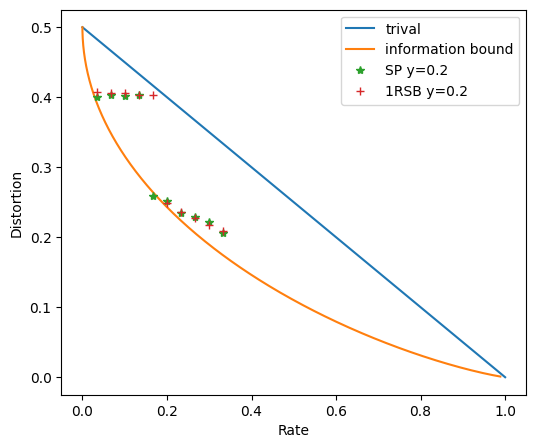

PyObject <matplotlib.legend.Legend object at 0x7fd59ef7f668>

In [203]:
using PyPlot
HH(p)=1+p*log2(p)+(1-p)*log2(1-p)
fig, ax = PyPlot.subplots(figsize=(6,5))
PyPlot.xlabel("Rate")
PyPlot.ylabel("Distortion")
PyPlot.plot((0,1),(0.5,0), label="trival")
PyPlot.plot(HH.(0:0.001:0.5), 0:0.001:0.5, label="information bound")
PyPlot.plot(Rs,D_sp, "*", label="SP y=0.2")
PyPlot.plot(Rs,D_rsb, "+", label="1RSB y=0.2")
legend()